In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings("ignore",category=ConvergenceWarning)
from math import sqrt
import plotly.express as px
from scipy.stats import boxcox
import plotly.graph_objects as go
from pandas.plotting import lag_plot
import statsmodels.formula.api as smf
from plotly.subplots import make_subplots
from statsmodels.tsa.holtwinters import Holt,SimpleExpSmoothing,ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
from google.colab import files
uploaded= files.upload()

Saving CocaCola_Sales_Rawdata.xlsx to CocaCola_Sales_Rawdata.xlsx


In [3]:
data=pd.read_excel("CocaCola_Sales_Rawdata.xlsx")
data.head(5)

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Quarter  42 non-null     object 
 1   Sales    42 non-null     float64
dtypes: float64(1), object(1)
memory usage: 800.0+ bytes


In [5]:
data.describe()

,Sales
count,42.000000
mean,2994.353308
std,977.930896
min,1547.818996
25%,2159.714247
50%,2782.376999
75%,3609.250000
max,5253.000000


In [6]:
data.isna().sum()

Quarter    0
Sales      0
dtype: int64

In [7]:
data.nunique()

Quarter    42
Sales      42
dtype: int64

In [8]:
data.duplicated().sum()

0

In [9]:
data['Quarter_Year']= data['Quarter'].str.split('_').apply(lambda x: " 19".join(x[:]))
data.head(5)

,Quarter,Sales,Quarter_Year
0,Q1_86,1734.827000,Q1 1986
1,Q2_86,2244.960999,Q2 1986
2,Q3_86,2533.804993,Q3 1986
3,Q4_86,2154.962997,Q4 1986
4,Q1_87,1547.818996,Q1 1987


In [10]:
data['Date']= (pd.to_datetime(data['Quarter_Year'].str.split(' ').apply(lambda x: "".join(x[::-1])),dayfirst=True))
data.head(5)

<ipython-input-10-e601a64b3f9c>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Date']= (pd.to_datetime(data['Quarter_Year'].str.split(' ').apply(lambda x: "".join(x[::-1])),dayfirst=True))


,Quarter,Sales,Quarter_Year,Date
0,Q1_86,1734.827000,Q1 1986,1986-01-01
1,Q2_86,2244.960999,Q2 1986,1986-04-01
2,Q3_86,2533.804993,Q3 1986,1986-07-01
3,Q4_86,2154.962997,Q4 1986,1986-10-01
4,Q1_87,1547.818996,Q1 1987,1987-01-01


In [11]:
data['Quarters'] = data['Quarter'].str[:2]
data.head(5)

,Quarter,Sales,Quarter_Year,Date,Quarters
0,Q1_86,1734.827000,Q1 1986,1986-01-01,Q1
1,Q2_86,2244.960999,Q2 1986,1986-04-01,Q2
2,Q3_86,2533.804993,Q3 1986,1986-07-01,Q3
3,Q4_86,2154.962997,Q4 1986,1986-10-01,Q4
4,Q1_87,1547.818996,Q1 1987,1987-01-01,Q1


In [12]:
dummy = pd.get_dummies(data['Quarters']).astype('int')
data1 = pd.concat([data, dummy], axis=1)
data1.head(4)

,Quarter,Sales,Quarter_Year,Date,Quarters,Q1,Q2,Q3,Q4
0,Q1_86,1734.827000,Q1 1986,1986-01-01,Q1,1,0,0,0
1,Q2_86,2244.960999,Q2 1986,1986-04-01,Q2,0,1,0,0
2,Q3_86,2533.804993,Q3 1986,1986-07-01,Q3,0,0,1,0
3,Q4_86,2154.962997,Q4 1986,1986-10-01,Q4,0,0,0,1


In [13]:
data1.drop(['Quarter','Quarter_Year'] , axis =1, inplace = True)
data1.head()

,Sales,Date,Quarters,Q1,Q2,Q3,Q4
0,1734.827000,1986-01-01,Q1,1,0,0,0
1,2244.960999,1986-04-01,Q2,0,1,0,0
2,2533.804993,1986-07-01,Q3,0,0,1,0
3,2154.962997,1986-10-01,Q4,0,0,0,1
4,1547.818996,1987-01-01,Q1,1,0,0,0


In [14]:
data1.set_index('Date',inplace=True)

In [15]:
data1.head(5)

,Sales,Quarters,Q1,Q2,Q3,Q4
Date,,,,,,
1986-01-01,1734.827000,Q1,1,0,0,0
1986-04-01,2244.960999,Q2,0,1,0,0
1986-07-01,2533.804993,Q3,0,0,1,0
1986-10-01,2154.962997,Q4,0,0,0,1
1987-01-01,1547.818996,Q1,1,0,0,0


In [16]:
data['Date']= pd.to_datetime(data.Date,format='%b-%y')
data['month']= data.Date.dt.strftime('%b')
data['year']= data.Date.dt.strftime('%y')
data.head(5)

,Quarter,Sales,Quarter_Year,Date,Quarters,month,year
0,Q1_86,1734.827000,Q1 1986,1986-01-01,Q1,Jan,86
1,Q2_86,2244.960999,Q2 1986,1986-04-01,Q2,Apr,86
2,Q3_86,2533.804993,Q3 1986,1986-07-01,Q3,Jul,86
3,Q4_86,2154.962997,Q4 1986,1986-10-01,Q4,Oct,86
4,Q1_87,1547.818996,Q1 1987,1987-01-01,Q1,Jan,87


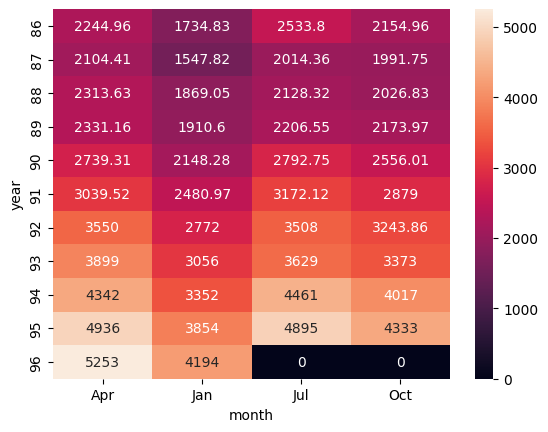

In [17]:
map= pd.pivot_table(data=data,values='Sales',index='year',columns='month',aggfunc='mean',fill_value=0)
sns.heatmap(map,annot=True,fmt="g")
plt.show()

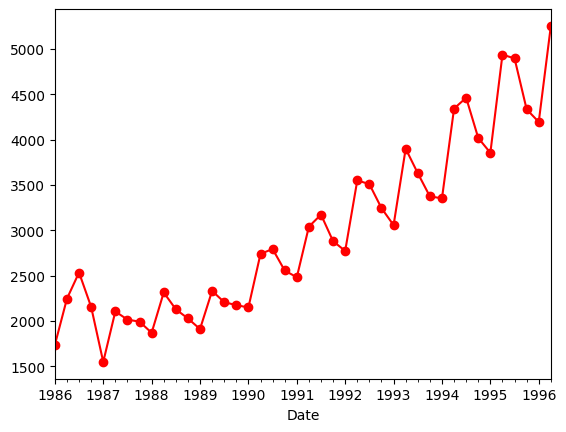

In [18]:
data1['Sales'].plot(color='red',marker='o')
plt.show()

There is an increasing Trend. So, Trend is not constant.
Variance is also not constant. hence time series is not stationary.

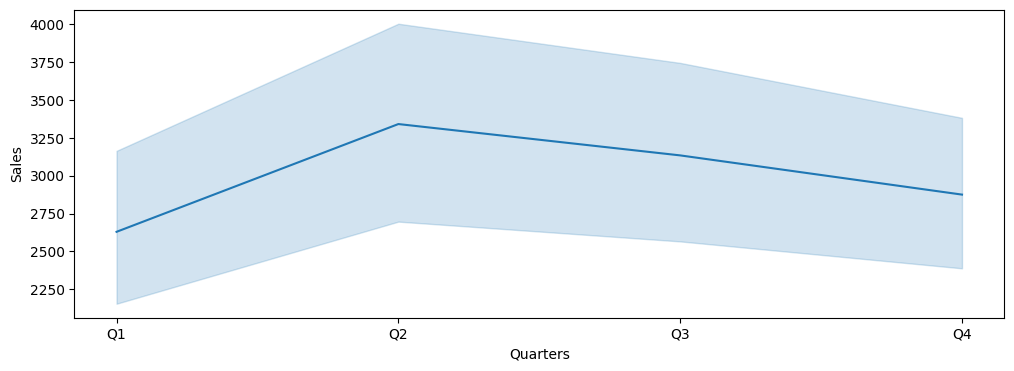

In [19]:
plt.figure(figsize=(12,4))
sns.lineplot(x='Quarters',y='Sales',data=data)
plt.show()

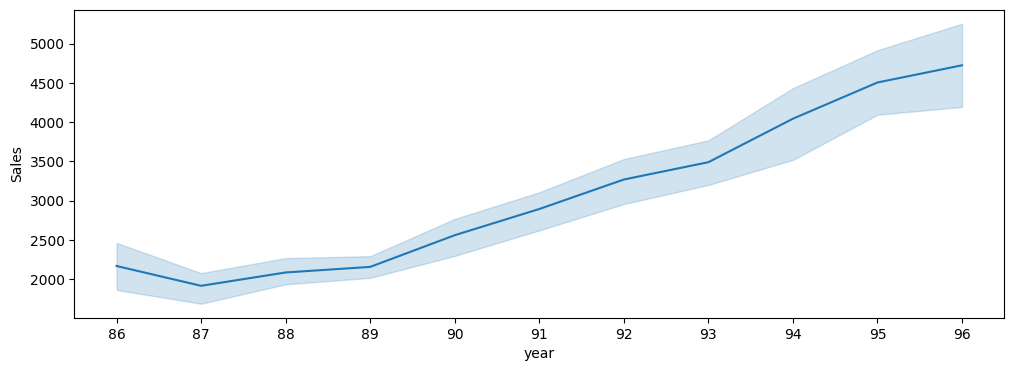

In [20]:
plt.figure(figsize=(12,4))
sns.lineplot(x='year',y='Sales',data=data)
plt.show()

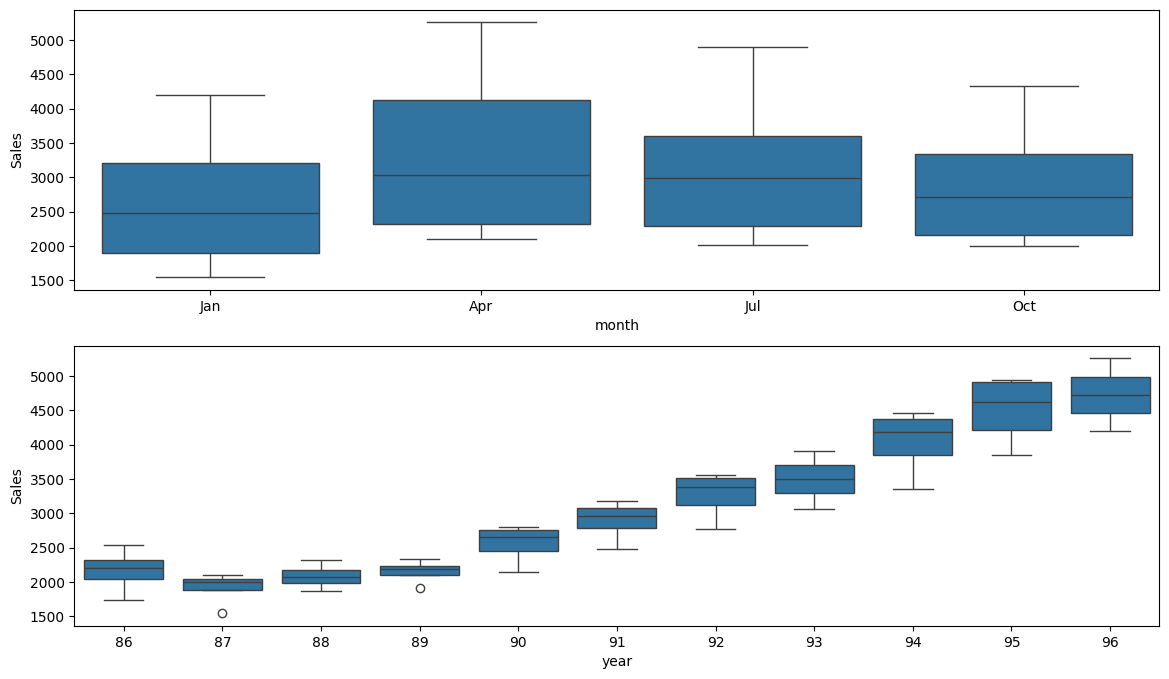

In [21]:
plt.figure(figsize=(14,8))
plt.subplot(211)
sns.boxplot(x="month",y="Sales",data=data)
plt.subplot(212)
sns.boxplot(x="year",y="Sales",data=data)
plt.show()

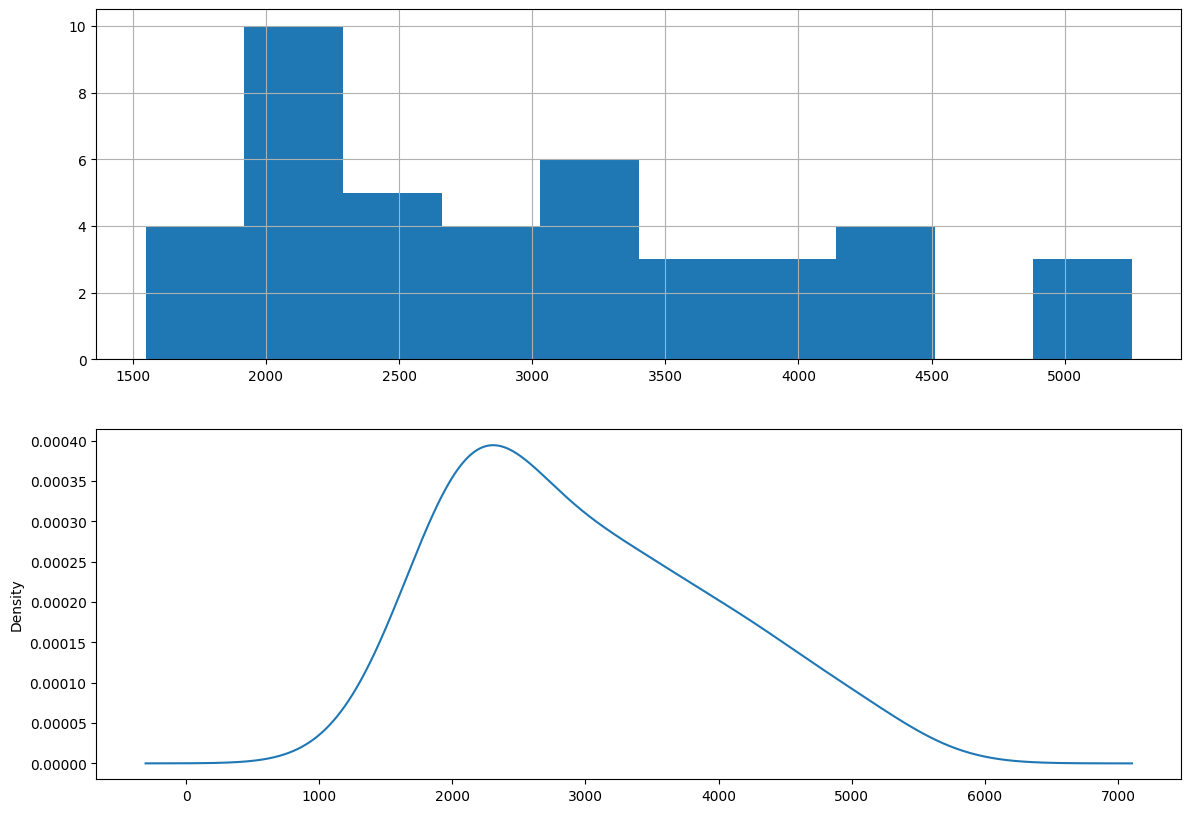

In [22]:
plt.figure(figsize=(14,10))
plt.subplot(211)
data.Sales.hist()
plt.subplot(212)
data.Sales.plot(kind='kde')
plt.show()

**a)LagPlot**

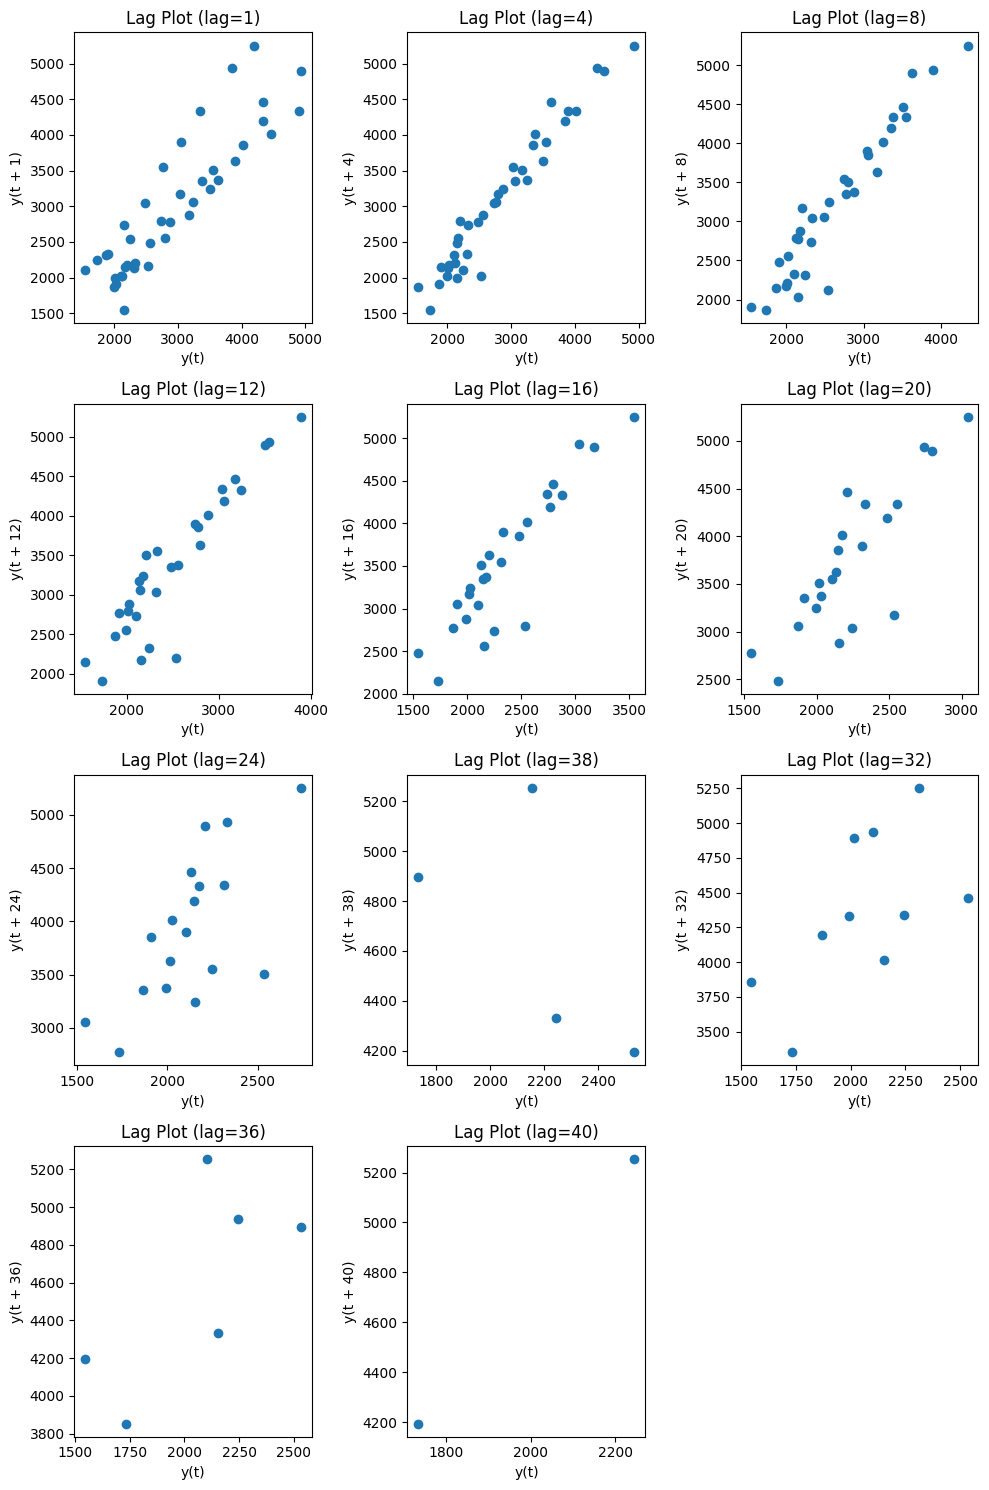

In [23]:
lag_values=[1, 4, 8, 12, 16, 20, 24, 38, 32, 36, 40]
plt.figure(figsize=(10, 15))
for i,lag in enumerate(lag_values,start=1):
  plt.subplot(4,3,i)
  lag_plot(data.Sales,lag=lag)
  plt.title(f"Lag Plot (lag={lag})")

plt.tight_layout()
plt.show()

**b)Moving Average**

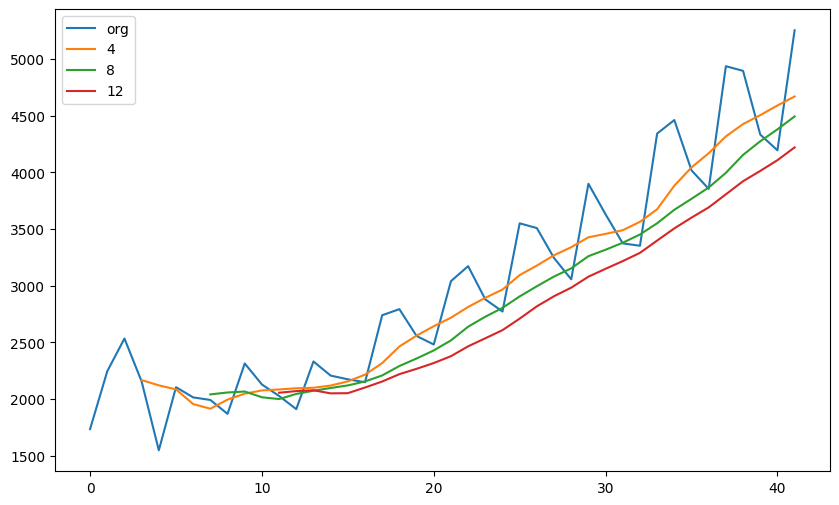

In [24]:
plt.figure(figsize=(10,6))
data.Sales.plot(label='org')
for i in range(4,13,4):
  data['Sales'].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')
plt.show()

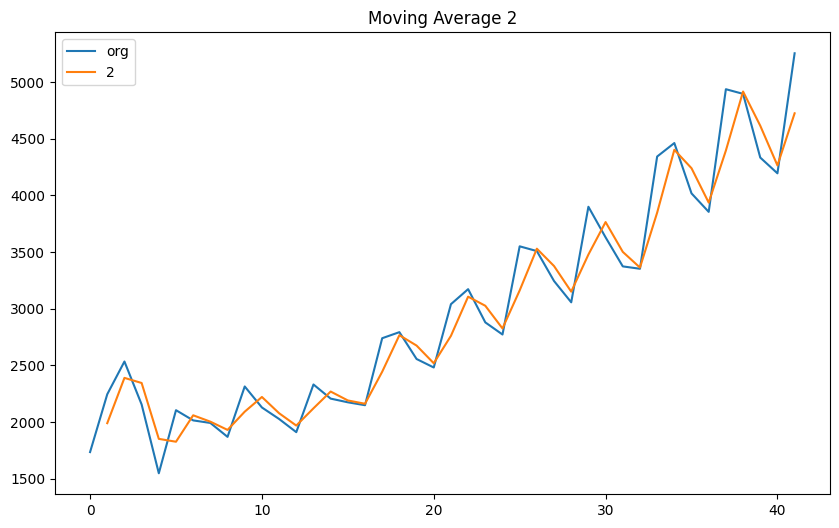

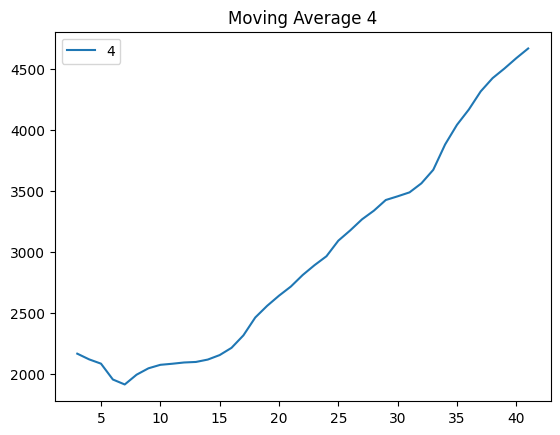

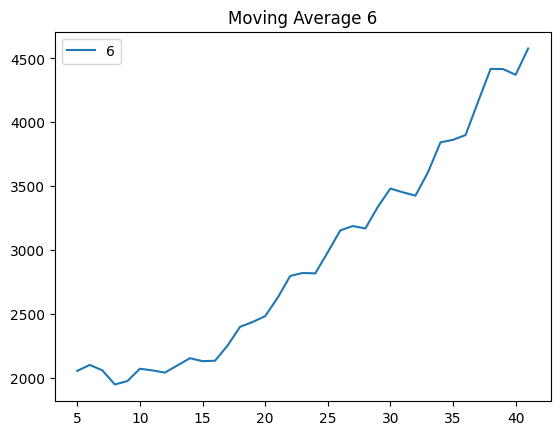

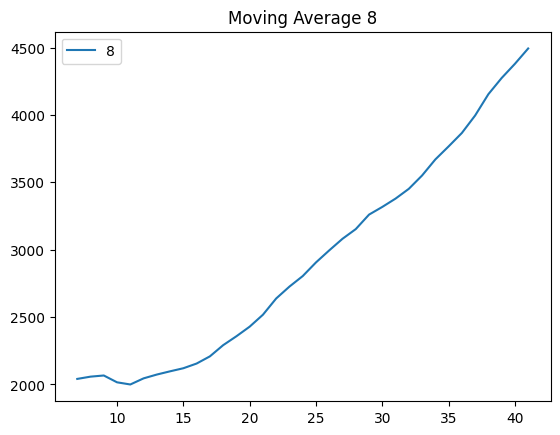

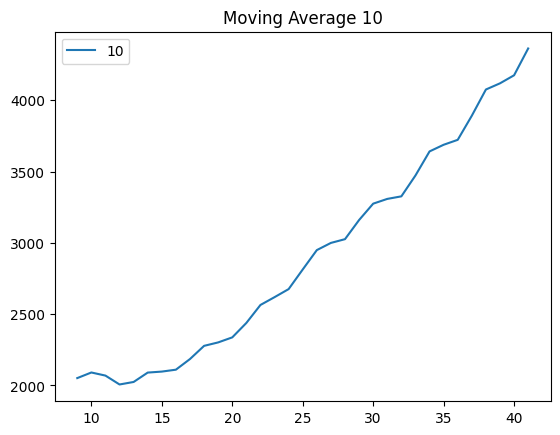

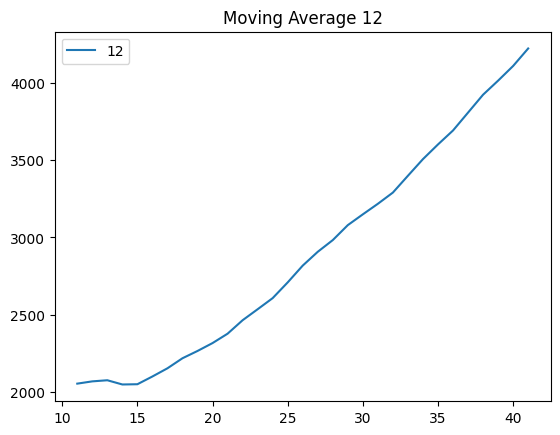

In [25]:
plt.figure(figsize=(10,6))
data.Sales.plot(label='org')
plt.title('Orginal Series')
for i in range(2,13,2):
  data['Sales'].rolling(i).mean().plot(label=str(i))
  plt.title("Moving Average "+str(i))
  plt.legend(loc='best')
  plt.show()

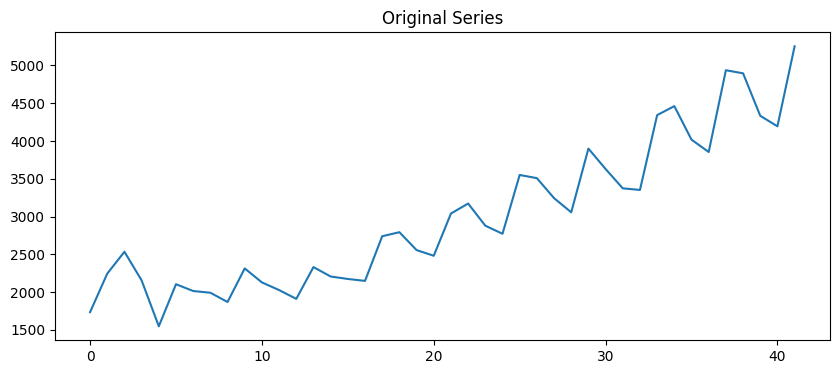

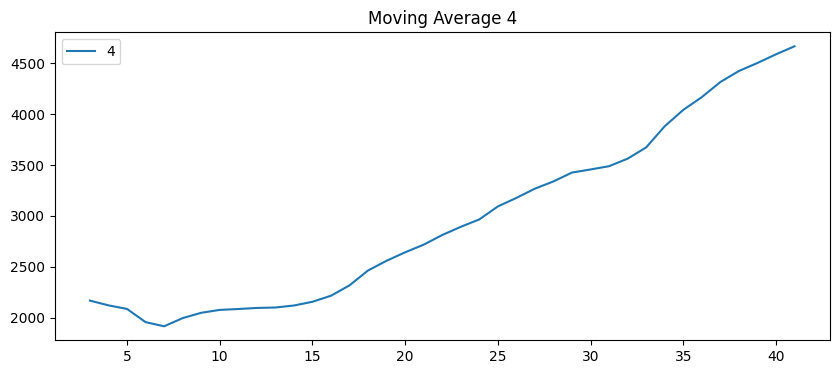

In [26]:
plt.figure(figsize=(10,4))
data.Sales.plot(label="org")
plt.title("Original Series")
plt.figure(figsize=(10,4))
data["Sales"].rolling(4).mean().plot(label=str(4))
plt.title("Moving Average "+str(4))
plt.legend(loc='best')
plt.show()

**c)Time series decomposition plot**


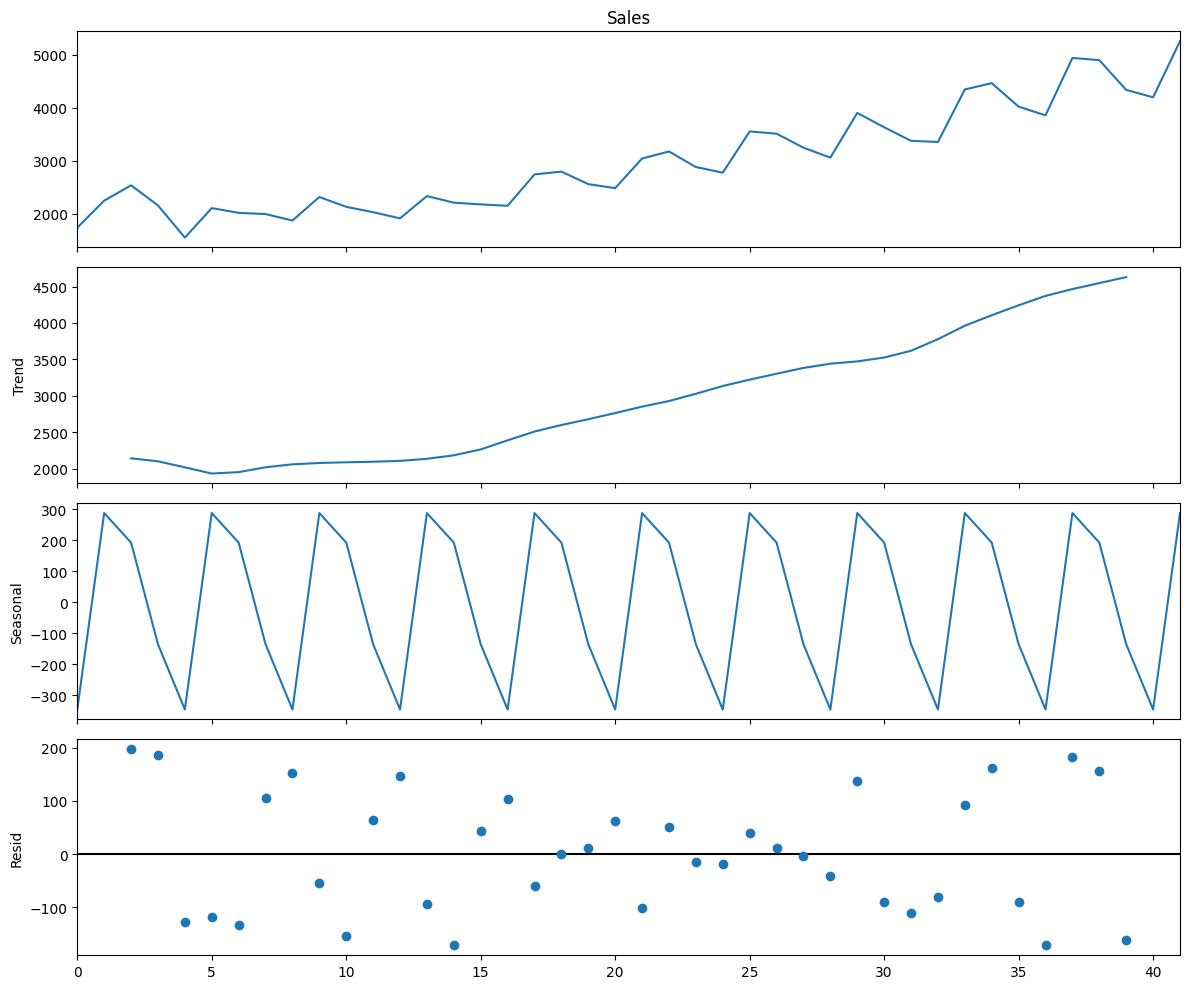

In [27]:
decompose_ts_add = seasonal_decompose(data.Sales,period=4)
with plt.rc_context():
    plt.rc("figure", figsize=(12,10))
    decompose_ts_add.plot()
    plt.show()

# **ACF plots and PACF plots**

a)Autocorrelation Function (ACF)

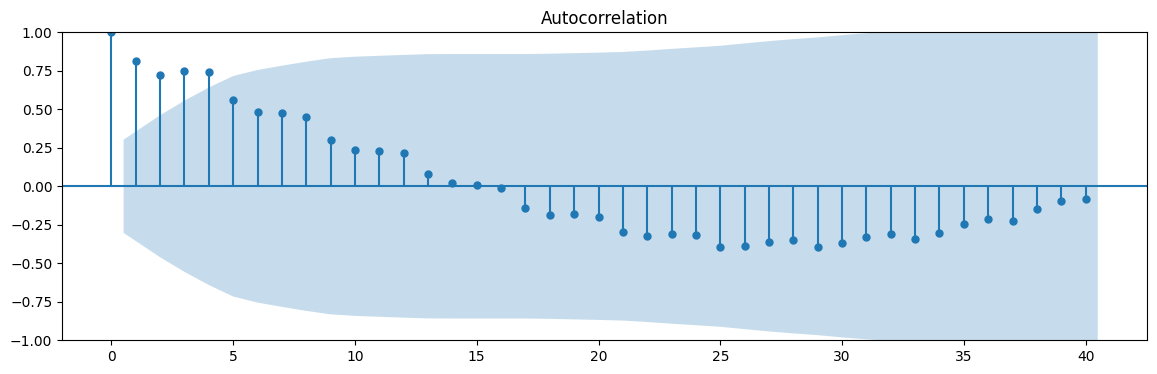

In [28]:
import statsmodels.graphics.tsaplots as tsa_plots
with plt.rc_context():
    plt.rc("figure", figsize=(14,4))
    tsa_plots.plot_acf(data.Sales,lags=40)
    plt.show()

b)Partial Autocorrelation Function (PACF)

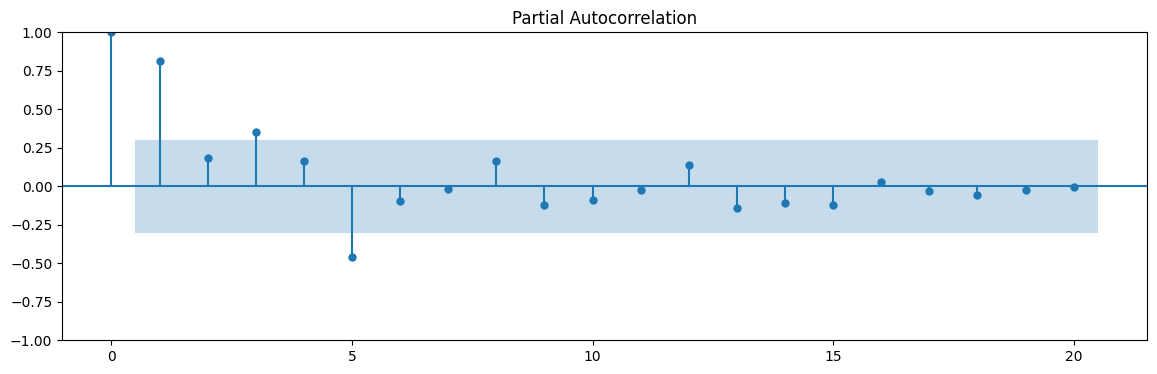

In [29]:
import statsmodels.graphics.tsaplots as tsa_plots
with plt.rc_context():
    plt.rc("figure", figsize=(14,4))
    tsa_plots.plot_pacf(data.Sales,lags=20)
    plt.show()

UpSampling with respect to month

In [30]:
upsampled_month = data1.drop(['Quarters','Q1','Q2','Q3','Q4'], axis=1)
upsampled_month = upsampled_month.resample('M').mean()
print(upsampled_month.head(5))

                  Sales
Date                   
1986-01-31  1734.827000
1986-02-28          NaN
1986-03-31          NaN
1986-04-30  2244.960999
1986-05-31          NaN


                  Sales
Date                   
1986-01-31  1734.827000
1986-02-28  1904.871666
1986-03-31  2074.916332
1986-04-30  2244.960999
1986-05-31  2341.242330


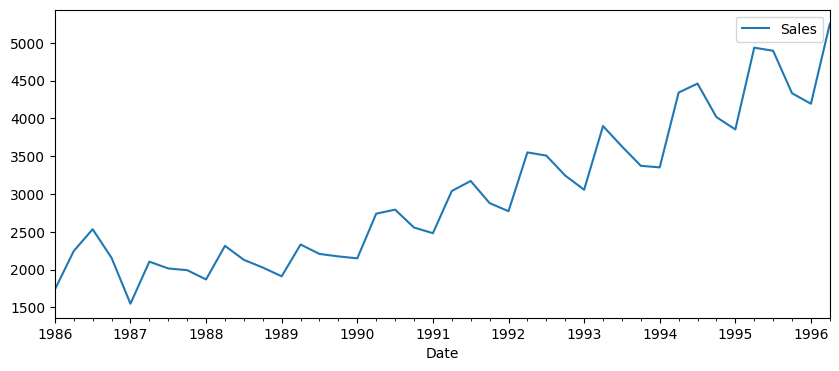

In [31]:
interpolated_month = upsampled_month.interpolate(method='linear')
print(interpolated_month.head(5))
interpolated_month.plot(figsize=(10,4))
plt.show()

In [32]:
interpolated_month

,Sales
Date,
1986-01-31,1734.827000
1986-02-28,1904.871666
1986-03-31,2074.916332
1986-04-30,2244.960999
1986-05-31,2341.242330
...,...
1995-12-31,4240.333333
1996-01-31,4194.000000
1996-02-29,4547.000000


In [33]:
visual = interpolated_month.copy()
visual.reset_index(inplace=True)
visual['date'] = pd.to_datetime(visual['Date'])
visual['year'] = visual['Date'].dt.year
visual['month'] = visual['Date'].dt.month
visual['week'] = visual['Date'].dt.isocalendar().week
visual['quarter'] = visual['Date'].dt.quarter
visual['day_of_week'] = visual['Date'].dt.day_name()
visual.drop('Date', axis =1 , inplace= True)
visual[:2]

,Sales,date,year,month,week,quarter,day_of_week
0,1734.827000,1986-01-31,1986,1,5,1,Friday
1,1904.871666,1986-02-28,1986,2,9,1,Friday


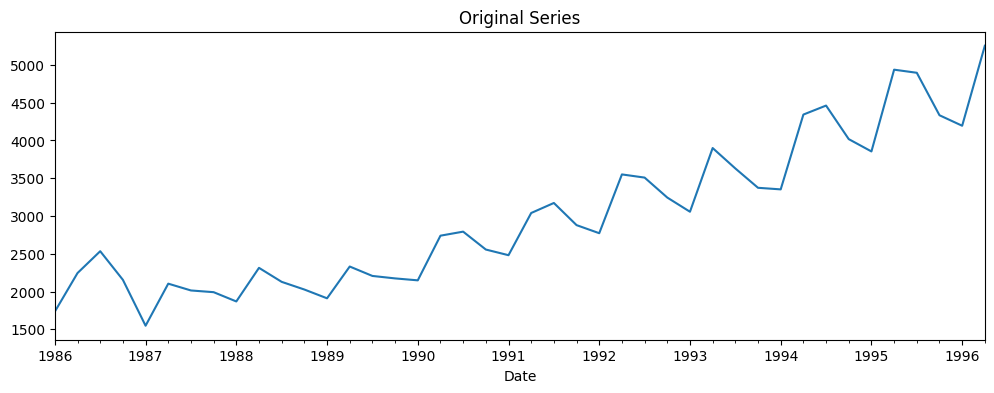

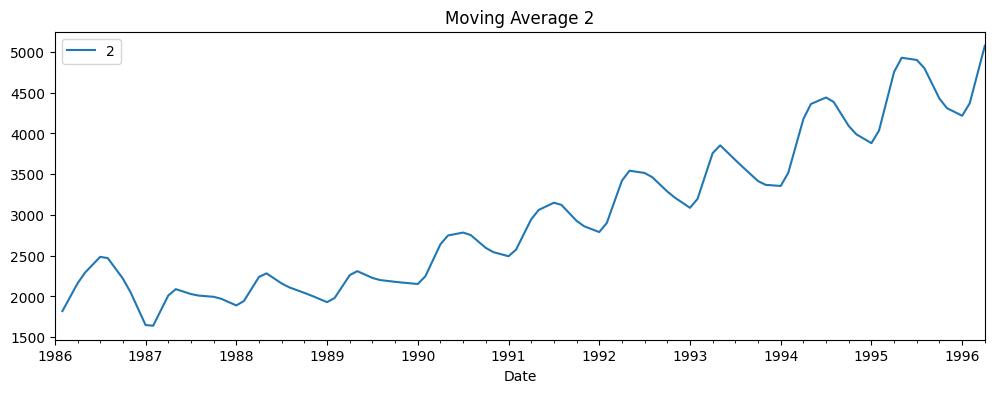

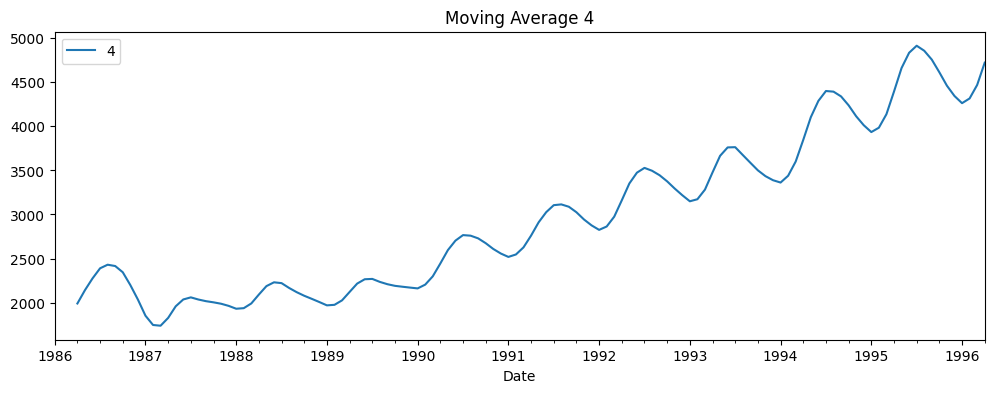

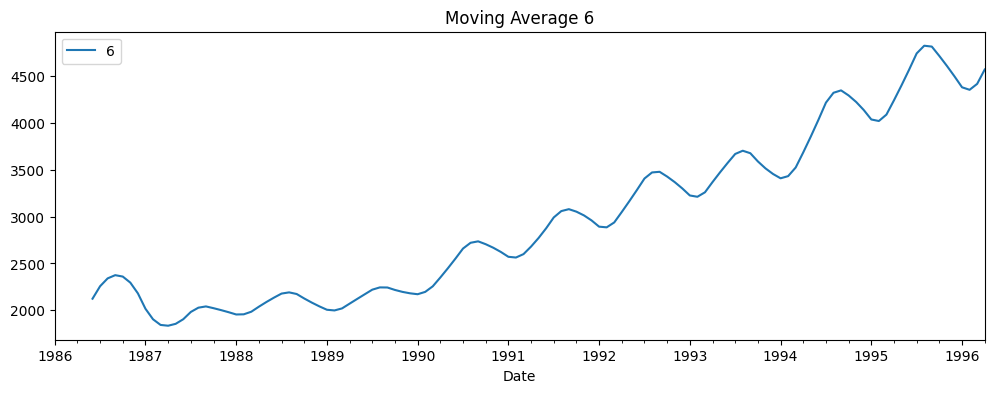

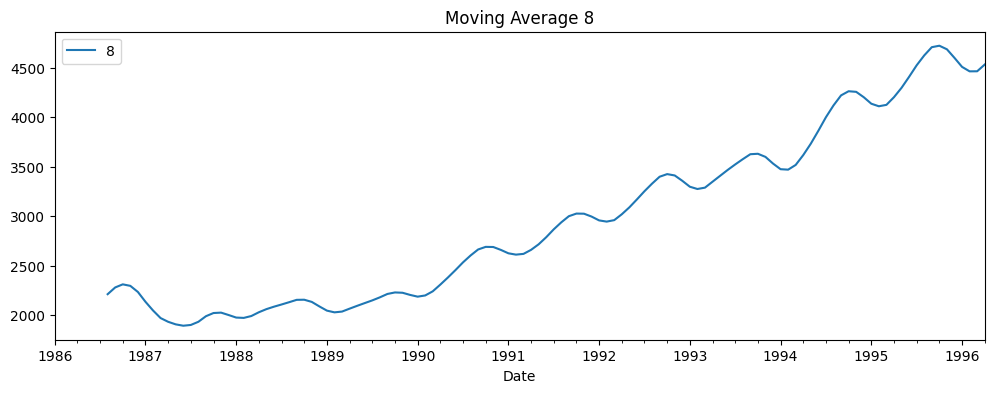

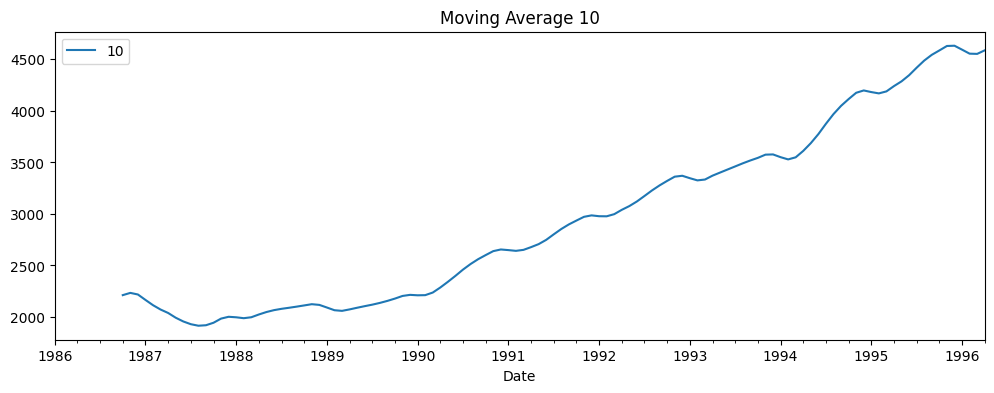

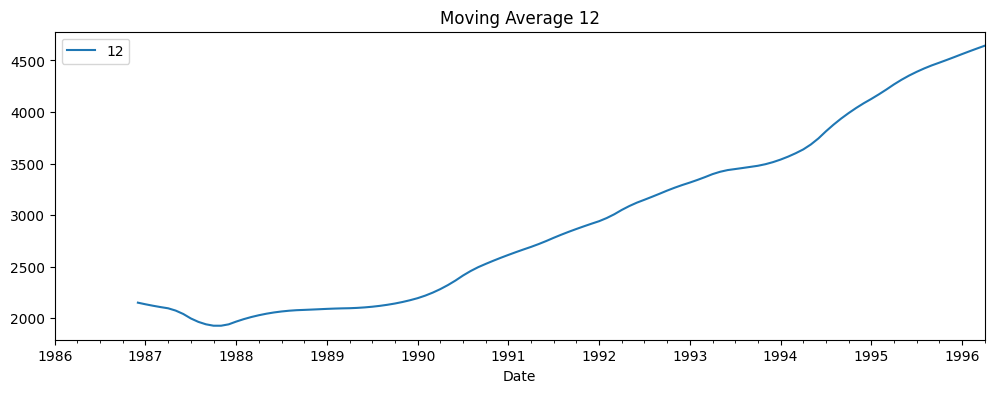

In [34]:
plt.figure(figsize=(12,4))
interpolated_month.Sales.plot(label="org")
plt.title("Original Series")
for i in range(2,13,2):
    plt.figure(figsize=(12,4))
    interpolated_month["Sales"].rolling(i).mean().plot(label=str(i))
    plt.title("Moving Average "+str(i))
    plt.legend(loc='best')
    plt.show()

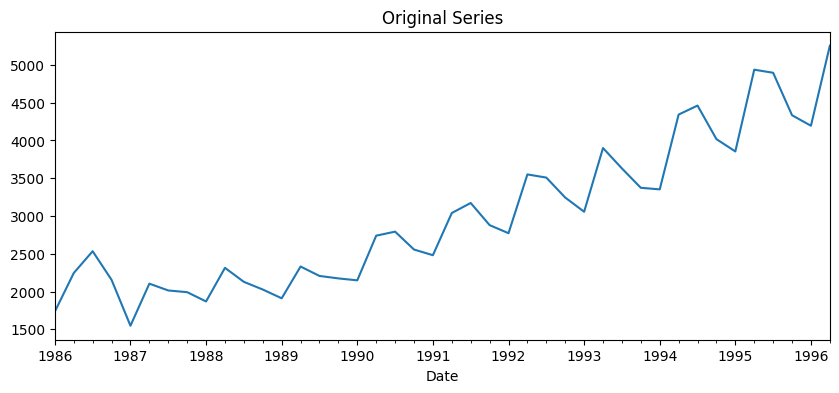

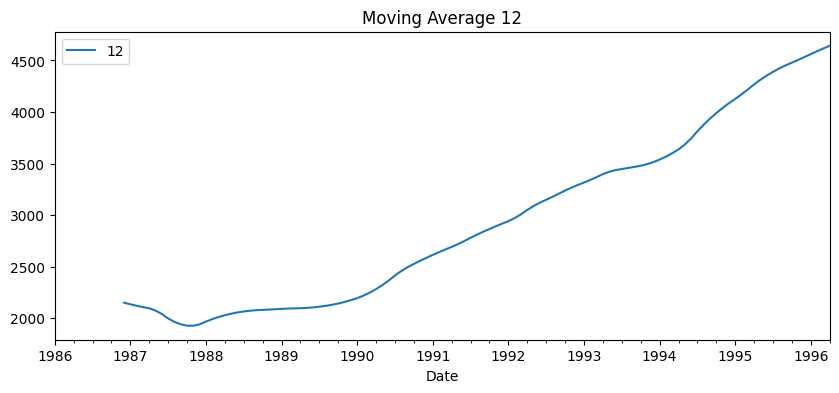

In [35]:
plt.figure(figsize=(10,4))
interpolated_month.Sales.plot(label="org")
plt.title("Original Series")
plt.figure(figsize=(10,4))
interpolated_month["Sales"].rolling(12).mean().plot(label=str(12))
plt.title("Moving Average "+str(12))
plt.legend(loc='best')
plt.show()

# **Time Series Decomposition**

a)Additive Seasonal Decomposition

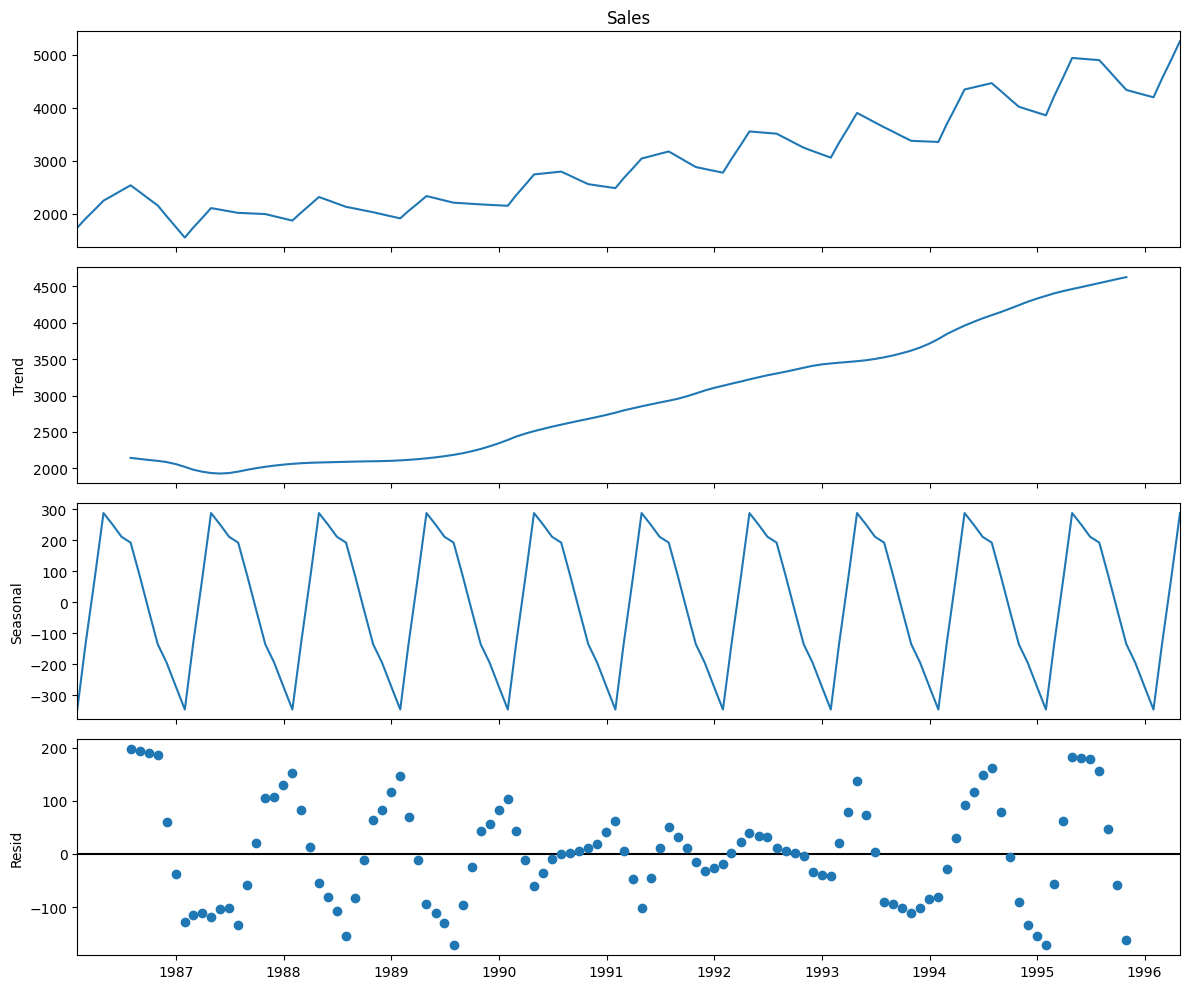

In [36]:
decompose_ts_add = seasonal_decompose(interpolated_month.Sales, period=12, model='additive')
with plt.rc_context():
    plt.rc("figure", figsize=(12,10))
    decompose_ts_add.plot()
    plt.show()

b)Multiplicative Seasonal Decomposition


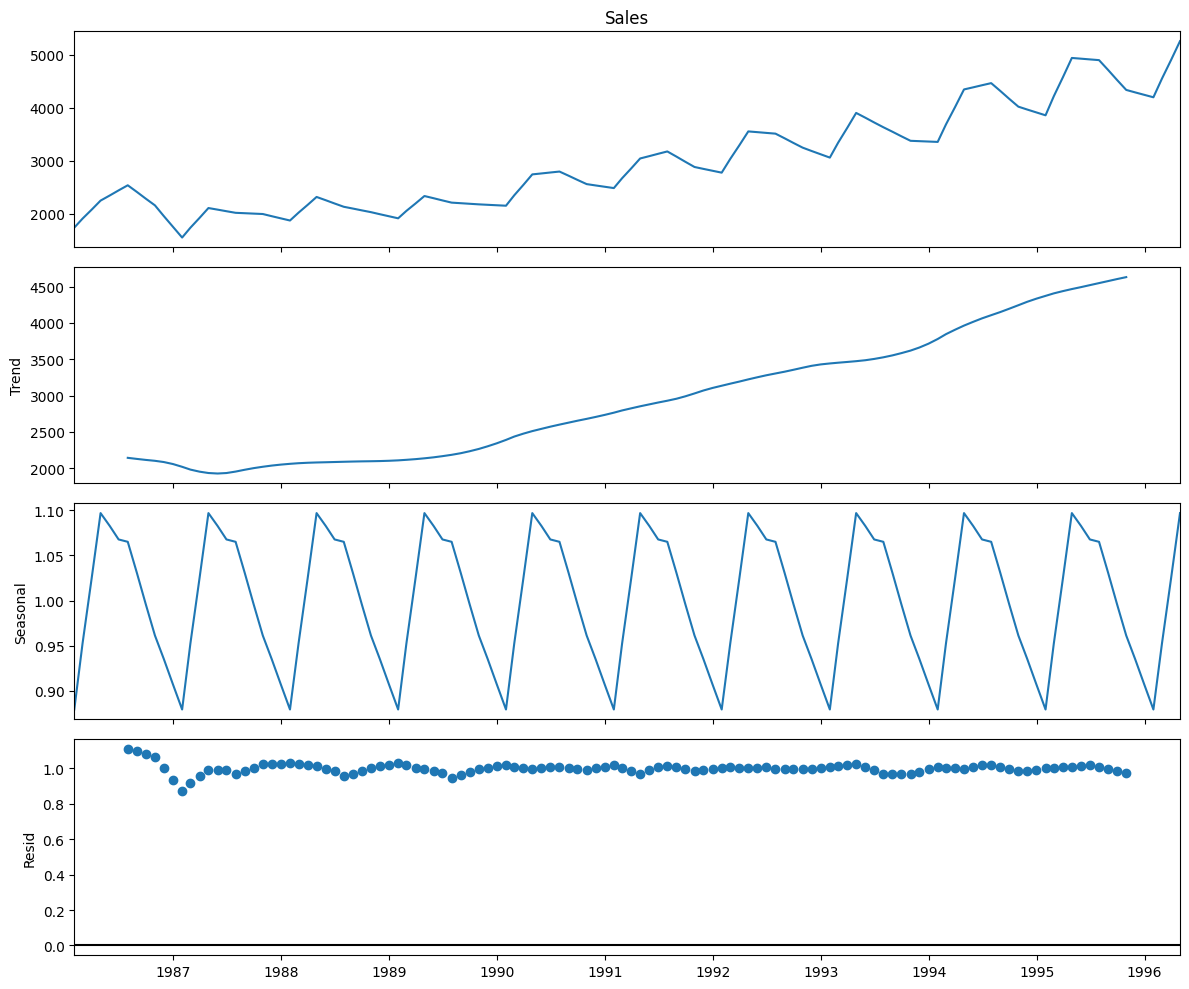

In [37]:
decompose_ts_add = seasonal_decompose(interpolated_month.Sales, period=12, model='multiplicative')
with plt.rc_context():
    plt.rc("figure", figsize=(12,10))
    decompose_ts_add.plot()
    plt.show()

# **Splitting Train and Test Data**

In [38]:
train_data = interpolated_month[:100]
test_data = interpolated_month[100:]

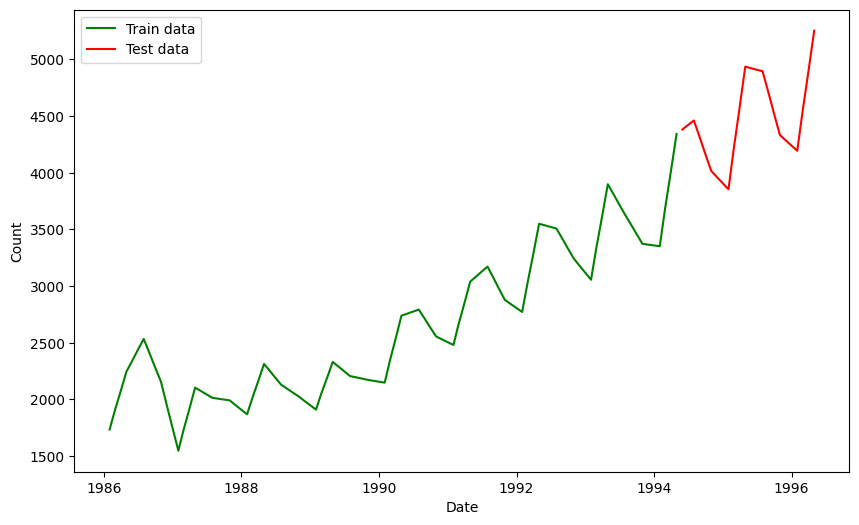

In [39]:
plt.figure(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Count')
plt.plot(train_data, 'green', label='Train data')
plt.plot(test_data, 'red', label='Test data')
plt.legend()
plt.show()

In [40]:
def MAPE(pred,org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)

# **Exponential Methods**


**a)Simple Exponential Method**

In [41]:
ses_model = SimpleExpSmoothing(train_data['Sales']).fit(optimized=True)
test_pred_ses = ses_model.forecast(24)
train_pred_ses = ses_model.fittedvalues
test_rmse_ses = sqrt(mean_squared_error(test_pred_ses,test_data.Sales))
train_rmse_ses = sqrt(mean_squared_error(train_pred_ses,train_data))
mape_ses = MAPE(test_pred_ses,test_data.Sales)
print('Simple Exponential Method Evaluation',"\n",\
'Mean Absolute Percent Error   = {}'.format(mape_ses),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ses),"\n",
'Test Root Mean Squared Error  = {}'.format(test_rmse_ses))

Simple Exponential Method Evaluation 
 Mean Absolute Percent Error   = 6.6197194272254025 
 Train Root Mean Squared Error = 129.37951431349904 
 Test Root Mean Squared Error  = 381.95422355078995


In [42]:
ses_model = SimpleExpSmoothing(train_data['Sales']).fit(optimized=True)
test_pred_ses = ses_model.predict(start = test_data.index[0],end = test_data.index[-1])
train_pred_ses = ses_model.fittedvalues
test_rmse_ses = sqrt(mean_squared_error(test_pred_ses,test_data.Sales))
train_rmse_ses = sqrt(mean_squared_error(train_pred_ses,train_data))
mape_ses = MAPE(test_pred_ses,test_data.Sales)
print('Simple Exponential Method Evaluation',"\n",\
'Mean Absolute Percent Error   = {}'.format(mape_ses),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ses),"\n",
'Test Root Mean Squared Error  = {}'.format(test_rmse_ses))

Simple Exponential Method Evaluation 
 Mean Absolute Percent Error   = 6.6197194272254025 
 Train Root Mean Squared Error = 129.37951431349904 
 Test Root Mean Squared Error  = 381.95422355078995


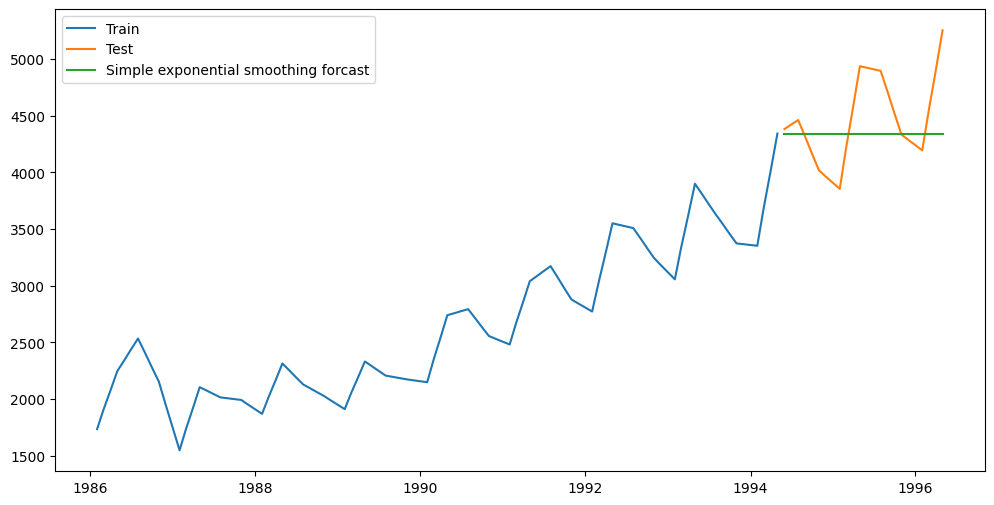

In [43]:
plt.figure(figsize=(12,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.legend(loc='best')
plt.show()

**b)Holt method (Double Exponential)**

In [44]:
dexp_model  = Holt(train_data).fit(optimized=True)
test_pred_dexp = dexp_model.forecast(24)
train_pred_dexp = dexp_model.fittedvalues
test_rmse_dexp = sqrt(mean_squared_error(test_pred_dexp,test_data.Sales))
train_rmse_dexp = sqrt(mean_squared_error(train_pred_dexp,train_data))
mape_dexp = MAPE(test_pred_dexp,test_data.Sales)
print('Simple Exponential Method Evaluation',"\n",\
'Mean Absolute Percent Error   = {}'.format(mape_dexp),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_dexp),"\n",
'Test Root Mean Squared Error  = {}'.format(test_rmse_dexp))

Simple Exponential Method Evaluation 
 Mean Absolute Percent Error   = 89.4931606588976 
 Train Root Mean Squared Error = 108.70855330066725 
 Test Root Mean Squared Error  = 4549.83259387513


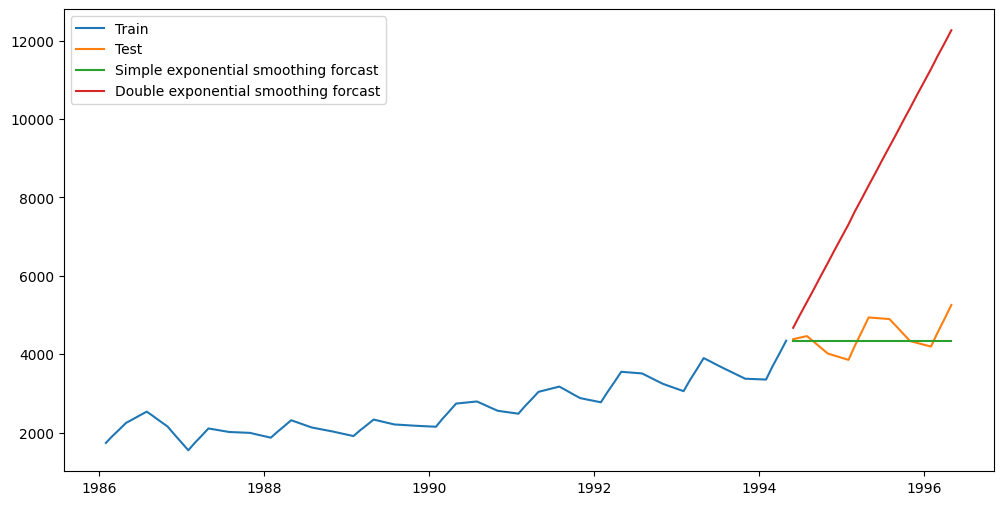

In [45]:
plt.figure(figsize=(12,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.legend(loc='best')
plt.show()

**c)Holts winter exponential smoothing with additive seasonality and trend (Triple Exponential)**

In [46]:
texp_add_model  = ExponentialSmoothing(train_data,seasonal="add",trend="add",seasonal_periods=12).fit(optimized=True)
test_pred_ad_texp = texp_add_model.forecast(24)
train_pred_ad_texp = texp_add_model.fittedvalues
test_rmse_ad_texp = sqrt(mean_squared_error(test_pred_ad_texp,test_data.Sales))
train_rmse_ad_texp = sqrt(mean_squared_error(train_pred_ad_texp,train_data))
mape_ad_texp = MAPE(test_pred_ad_texp,test_data.Sales)
print('Triple Exponential with Additive Trend and Seosonality Method Evaluation',"\n",\
'Mean Absolute Percent Error   = {}'.format(mape_ad_texp),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ad_texp),"\n",
'Test Root Mean Squared Error  = {}'.format(test_rmse_ad_texp))

Triple Exponential with Additive Trend and Seosonality Method Evaluation 
 Mean Absolute Percent Error   = 35.69571274324909 
 Train Root Mean Squared Error = 44.2653652251861 
 Test Root Mean Squared Error  = 1828.4767720554398


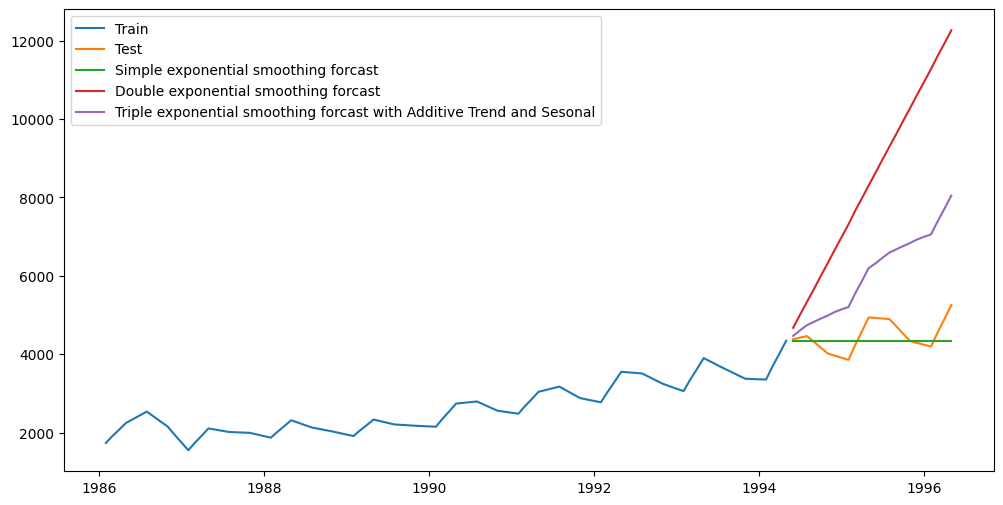

In [47]:
plt.figure(figsize=(12,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.legend(loc='best')
plt.show()

**d)Holts winter exponential smoothing with multiplicative seasonality and additive trend**

In [48]:
texp_mul_ad_model  = ExponentialSmoothing(train_data,seasonal="mul",trend="add",seasonal_periods=12).fit(optimized=True)
test_pred_mul_ad_texp = texp_mul_ad_model.forecast(24)
train_pred_mul_ad_texp = texp_mul_ad_model.fittedvalues
test_rmse_mul_ad_texp = sqrt(mean_squared_error(test_pred_mul_ad_texp,test_data.Sales))
train_rmse_mul_ad_texp = sqrt(mean_squared_error(train_pred_mul_ad_texp,train_data))
mape_mul_ad_texp = MAPE(test_pred_mul_ad_texp,test_data.Sales)
print('Triple Exponential Method with Multiplicative Seasonality and Additive Trend',"\n",\
'Mean Absolute Percent Error   = {}'.format(mape_mul_ad_texp),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_mul_ad_texp),"\n",
'Test Root Mean Squared Error  = {}'.format(test_rmse_mul_ad_texp))

Triple Exponential Method with Multiplicative Seasonality and Additive Trend 
 Mean Absolute Percent Error   = 1.487268775553493 
 Train Root Mean Squared Error = 50.223974444654 
 Test Root Mean Squared Error  = 78.73325826552858


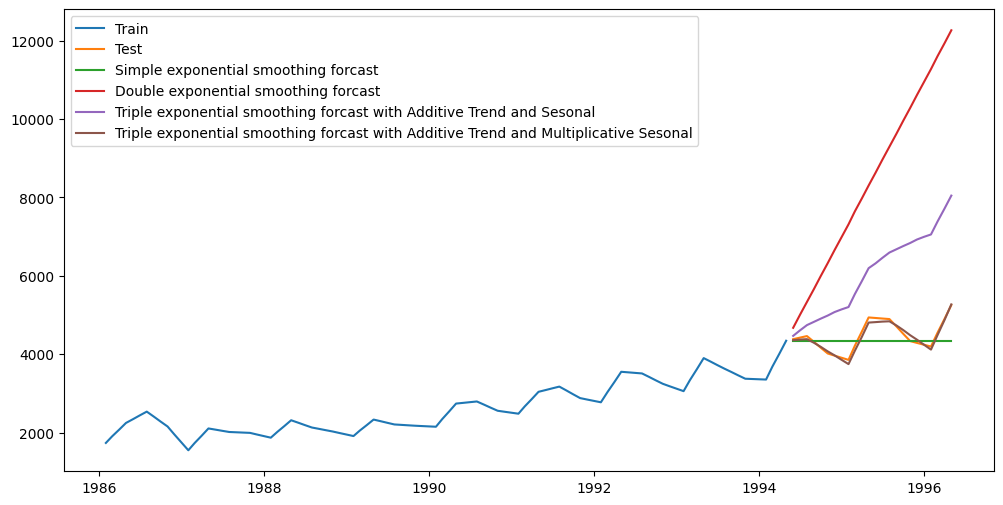

In [49]:
plt.figure(figsize=(12,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.plot(test_pred_mul_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Multiplicative Sesonal')
plt.legend(loc='best')
plt.show()

**e)Holts winter exponential smoothing with Additive seasonality and multiplicative trend (Triple Exponential)**

In [50]:
texp_ad_mul_model  = ExponentialSmoothing(train_data,seasonal="add",trend="mul",seasonal_periods=12).fit(smoothing_level=0.1, smoothing_slope=0.5)
test_pred_ad_mul_texp  = texp_ad_mul_model.forecast(24)
train_pred_ad_mul_texp  = texp_ad_mul_model.fittedvalues
test_rmse_ad_mul_texp  = sqrt(mean_squared_error(test_pred_ad_mul_texp ,test_data.Sales))
train_rmse_ad_mul_texp  = sqrt(mean_squared_error(train_pred_ad_mul_texp ,train_data))
mape_ad_mul_texp  = MAPE(test_pred_ad_mul_texp,test_data.Sales)
print('Triple Exponential Method with Additive Seasonality and Multiplicative Trend',"\n",\
'Mean Absolute Percent Error   = {}'.format(mape_ad_mul_texp ),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ad_mul_texp ),"\n",
'Test Root Mean Squared Error  = {}'.format(test_rmse_ad_mul_texp ))

Triple Exponential Method with Additive Seasonality and Multiplicative Trend 
 Mean Absolute Percent Error   = 5.168784154878948 
 Train Root Mean Squared Error = 165.78104360617877 
 Test Root Mean Squared Error  = 270.08479145849486


<ipython-input-50-06a9273b748b>:1: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  texp_ad_mul_model  = ExponentialSmoothing(train_data,seasonal="add",trend="mul",seasonal_periods=12).fit(smoothing_level=0.1, smoothing_slope=0.5)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


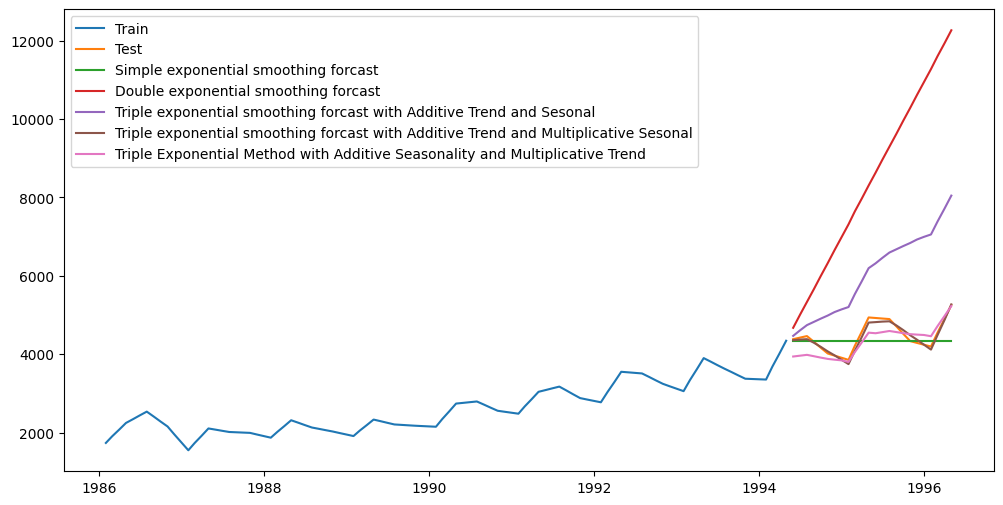

In [51]:
plt.figure(figsize=(12,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.plot(test_pred_mul_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Multiplicative Sesonal')
plt.plot(test_pred_ad_mul_texp, label='Triple Exponential Method with Additive Seasonality and Multiplicative Trend')
plt.legend(loc='best')
plt.show()

**f)Holts winter exponential smoothing with multiplicative seasonality and multiplicative trend**

In [52]:
texp_mul_model  = ExponentialSmoothing(train_data,seasonal="mul",trend="mul",seasonal_periods=12).fit(optimized=True)
test_pred_mul_texp  = texp_mul_model.forecast(24)
train_pred_mul_texp  = texp_mul_model.fittedvalues
test_rmse_mul_texp  = sqrt(mean_squared_error(test_pred_mul_texp ,test_data.Sales))
train_rmse_mul_texp  = sqrt(mean_squared_error(train_pred_mul_texp ,train_data))
mape_mul_texp  = MAPE(test_pred_mul_texp,test_data.Sales)
print('Triple Exponential Method with multiplicative Trend and Seasonality',"\n",\
'Mean Absolute Percent Error   = {}'.format(mape_mul_texp ),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_mul_texp ),"\n",
'Test Root Mean Squared Error  = {}'.format(test_rmse_mul_texp ))

Triple Exponential Method with multiplicative Trend and Seasonality 
 Mean Absolute Percent Error   = 1.8078233252851952 
 Train Root Mean Squared Error = 49.43910507382248 
 Test Root Mean Squared Error  = 101.65134880354205


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


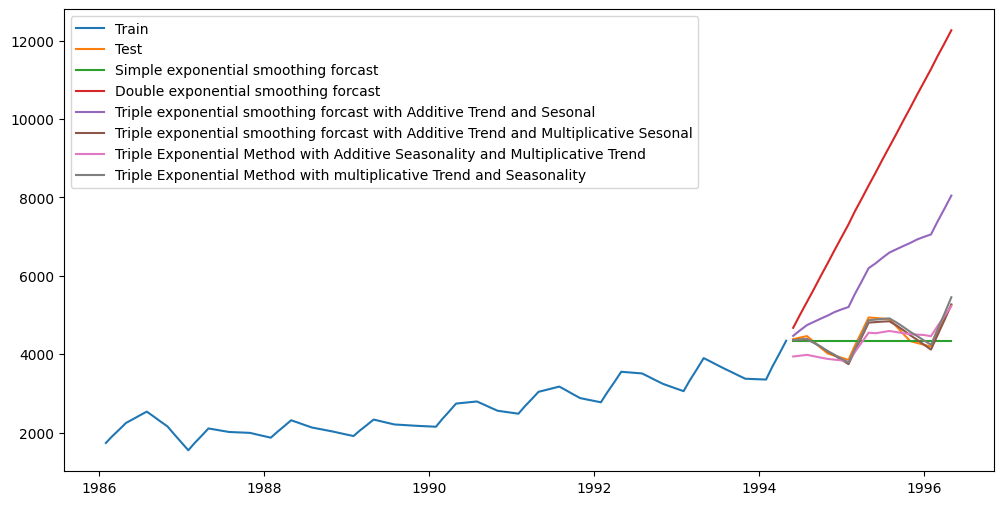

In [53]:
plt.figure(figsize=(12,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.plot(test_pred_mul_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Multiplicative Sesonal')
plt.plot(test_pred_ad_mul_texp, label='Triple Exponential Method with Additive Seasonality and Multiplicative Trend')
plt.plot(test_pred_mul_texp, label='Triple Exponential Method with multiplicative Trend and Seasonality')
plt.legend(loc='best')
plt.show()

**Comparing the results**

In [54]:
Evaluation = {"Models":pd.Series(["Simple_Exp","Double_Exp","Triple_Exp_Add","Triple_Exp_Mul_Add","Triple_Exp_Add_Mul","Triple_Exp_Mul"]),
        "Train_RMSE":pd.Series([train_rmse_ses,train_rmse_dexp,train_rmse_ad_texp,train_rmse_mul_ad_texp,train_rmse_ad_mul_texp,train_rmse_mul_texp]),
        "Test_MAPE(%)":pd.Series([mape_ses,mape_dexp,mape_ad_texp,mape_mul_ad_texp,mape_ad_mul_texp,mape_mul_texp]),
        "Test_RMSE_Values":pd.Series([test_rmse_ses,test_rmse_dexp,test_rmse_ad_texp,test_rmse_mul_ad_texp,test_rmse_ad_mul_texp,test_rmse_mul_texp])}
table_evaluation=pd.DataFrame(Evaluation)
table_evaluation.sort_values(['Test_MAPE(%)'], inplace=True, ignore_index=True)
table_evaluation

,Models,Train_RMSE,Test_MAPE(%),Test_RMSE_Values
0,Triple_Exp_Mul_Add,50.223974,1.487269,78.733258
1,Triple_Exp_Mul,49.439105,1.807823,101.651349
2,Triple_Exp_Add_Mul,165.781044,5.168784,270.084791
3,Simple_Exp,129.379514,6.619719,381.954224
4,Triple_Exp_Add,44.265365,35.695713,1828.476772
5,Double_Exp,108.708553,89.493161,4549.832594


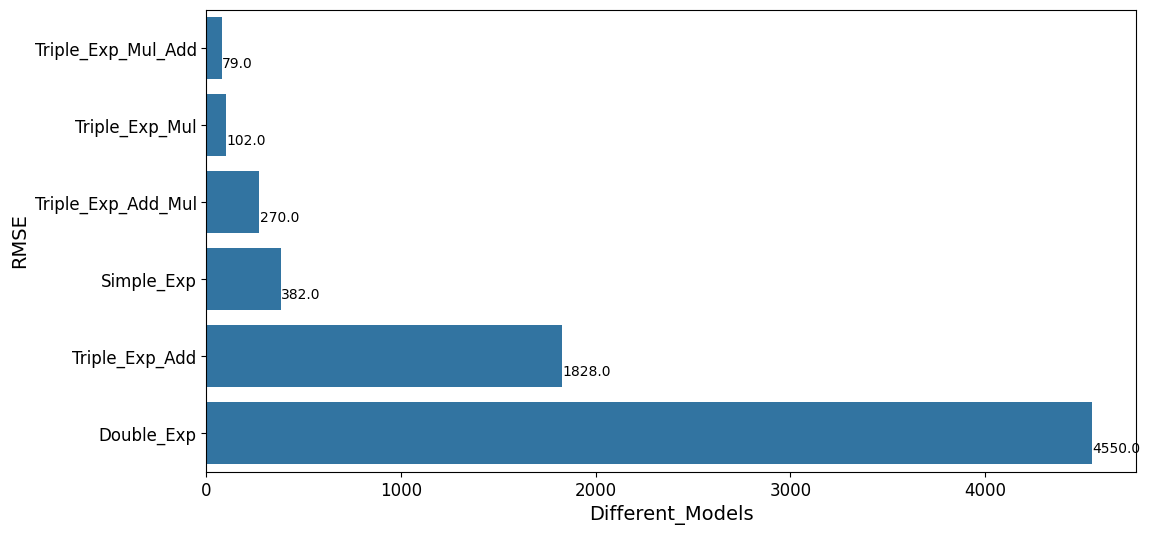

In [55]:
f, axe = plt.subplots(1,1, figsize=(12,6))
sns.barplot(x='Test_RMSE_Values', y='Models', data=table_evaluation, ax = axe)
axe.set_xlabel('Different_Models', size=14)
axe.set_ylabel('RMSE', size=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

for i, v in enumerate(np.round(table_evaluation.Test_RMSE_Values.values,0)):
    axe.text(v + 3, i + .25, str(v), fontsize= 10)
plt.show()

<ipython-input-56-326fe223c2ae>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Train_RMSE', y='Models', data = train_rmse, palette='Blues_d', ax = axes[0])
<ipython-input-56-326fe223c2ae>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Test_RMSE_Values', y='Models', data = test_rmse, palette='Reds_d', ax = axes[1])


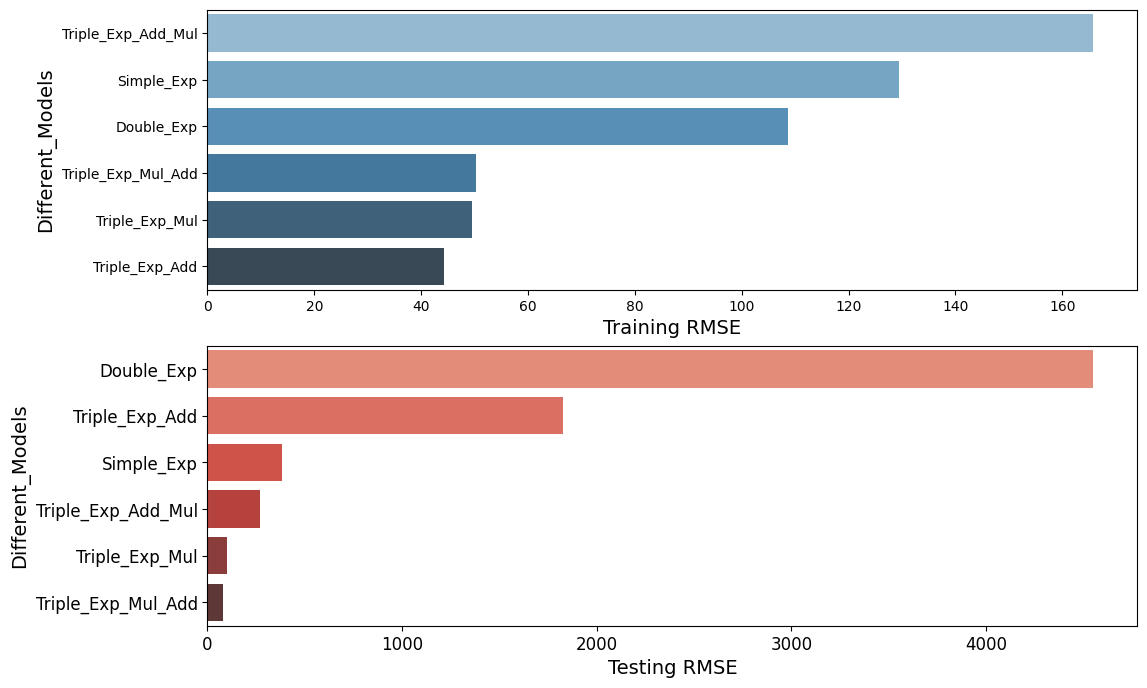

In [56]:
f, axes = plt.subplots(2,1, figsize=(12,8))
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

train_rmse = table_evaluation.sort_values(by=['Train_RMSE'], ascending=False)

sns.barplot(x='Train_RMSE', y='Models', data = train_rmse, palette='Blues_d', ax = axes[0])
axes[0].set_xlabel('Training RMSE', size=14)
axes[0].set_ylabel('Different_Models', size=14)

test_rmse = table_evaluation.sort_values(by=['Test_RMSE_Values'], ascending=False)

sns.barplot(x='Test_RMSE_Values', y='Models', data = test_rmse, palette='Reds_d', ax = axes[1])
axes[1].set_xlabel('Testing RMSE', size=14)
axes[1].set_ylabel('Different_Models', size=14)

plt.show()

**Autoregressive Integrated Moving Averages (ARIMA)**

In [57]:
def test_stationarity(timeseries):

    movingAverage = timeseries.rolling(window=4).mean()
    movingSTD = timeseries.rolling(window=4).std()

    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show(block=False)

    # Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['Sales'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

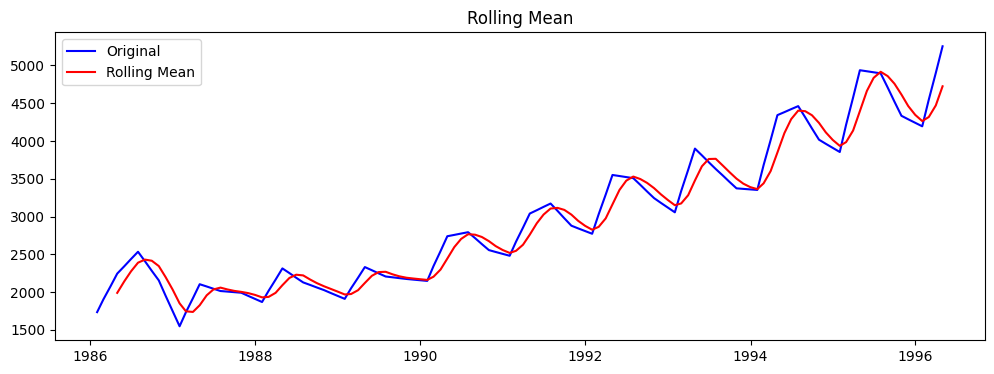

Results of Dickey Fuller Test:
Test Statistic                   0.572599
p-value                          0.986920
#Lags Used                      10.000000
Number of Observations Used    113.000000
Critical Value (1%)             -3.489590
Critical Value (5%)             -2.887477
Critical Value (10%)            -2.580604
dtype: float64


In [58]:
plt.figure(figsize=(12,4))
sales= pd.DataFrame()
sales['Sales'] = interpolated_month[['Sales']]
test_stationarity(sales)

In [59]:
def adf_test(series):
    result = adfuller(series.dropna())
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    if result[1] <= 0.05:
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [60]:
adf_test(sales.Sales)

Fail to reject the null hypothesis
Data is non-stationary


**Box Cox Transformation**

,Sales
Date,
1986-01-31,7.458663
1986-02-28,7.552170
1986-03-31,7.637676
1986-04-30,7.716443
1986-05-31,7.758437


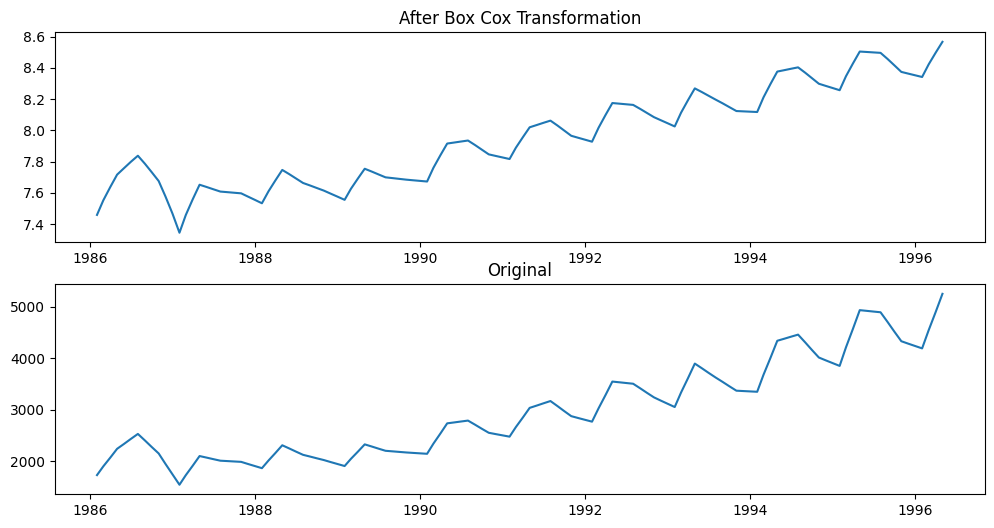

In [61]:
data_boxcox = pd.DataFrame()
data_boxcox['Sales'] = pd.Series(boxcox(interpolated_month['Sales'], lmbda=0), interpolated_month.index)
display(data_boxcox.head())
fig, axis = plt.subplots(2,figsize=(12,6),)
axis[0].plot(data_boxcox)
axis[0].set_title('After Box Cox Transformation')
axis[1].plot(interpolated_month, label='original')
axis[1].set_title('Original')
plt.show()

The variance became almost constant after the transformation.

The series has an upward trend

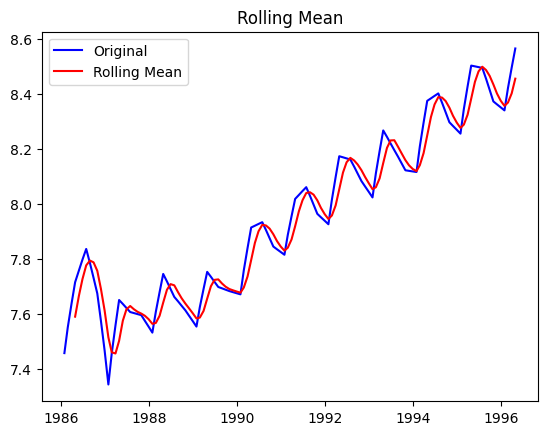

Results of Dickey Fuller Test:
Test Statistic                   0.451508
p-value                          0.983322
#Lags Used                      13.000000
Number of Observations Used    110.000000
Critical Value (1%)             -3.491245
Critical Value (5%)             -2.888195
Critical Value (10%)            -2.580988
dtype: float64


In [62]:
test_stationarity(data_boxcox)

In [63]:
adf_test(data_boxcox)

Fail to reject the null hypothesis
Data is non-stationary


**Differencing of the Box-Cox Transformation**

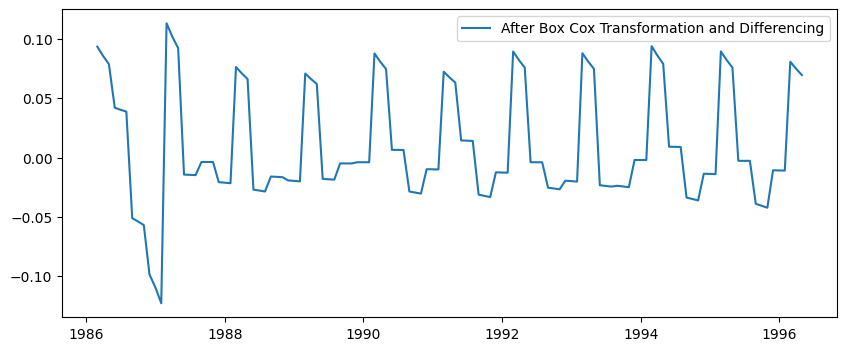

In [64]:
data_boxcox_diff = data_boxcox - data_boxcox.shift()
data_boxcox_diff.dropna(inplace=True)
plt.figure(figsize=(10,4))
plt.plot(data_boxcox_diff, label='After Box Cox Transformation and Differencing')
plt.legend(loc='best')
plt.show()

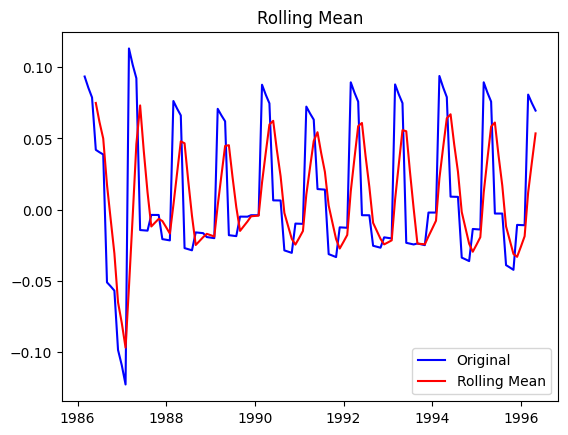

Results of Dickey Fuller Test:
Test Statistic                  -3.030060
p-value                          0.032181
#Lags Used                      12.000000
Number of Observations Used    110.000000
Critical Value (1%)             -3.491245
Critical Value (5%)             -2.888195
Critical Value (10%)            -2.580988
dtype: float64


In [65]:
test_stationarity(data_boxcox_diff)

In [66]:
adf_test(data_boxcox_diff.Sales)

Reject the null hypothesis
Data is stationary


In [67]:
train_data_boxcox = data_boxcox[:100]
test_data_boxcox = data_boxcox[100:]
train_data_boxcox_diff = data_boxcox_diff[:99]
test_data_boxcox_diff = data_boxcox_diff[99:]

# **ARIMA Hyperparameter Tuning**

In [68]:
def evaluate_arima_model(X, arima_order):

# Prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.70)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]

# Make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])

# Calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

# Evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:best_score, best_cfg = rmse, order
                except Exception as e:
                    print(e)
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [69]:
p_values = range(0,5)
d_values = range(0,5)
q_values = range(0,5)
evaluate_models(train_data_boxcox_diff.Sales, p_values, d_values, q_values)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.p

Best ARIMA(3, 0, 2) RMSE=0.028


**Inverse transformation of the Box-Cox Differencing**

In [70]:
model = ARIMA(train_data_boxcox_diff, order=(3, 0, 2))
model_fit = model.fit()
y_hat_ar = data_boxcox_diff.copy()
y_hat_ar['arima_forecast'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ar['arima_forecast'] = y_hat_ar['arima_forecast'].cumsum()
y_hat_ar['arima_forecast'] = y_hat_ar['arima_forecast'].add(data_boxcox.Sales[0])
y_hat_ar['arima_forecast'] = np.exp(y_hat_ar['arima_forecast'])

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


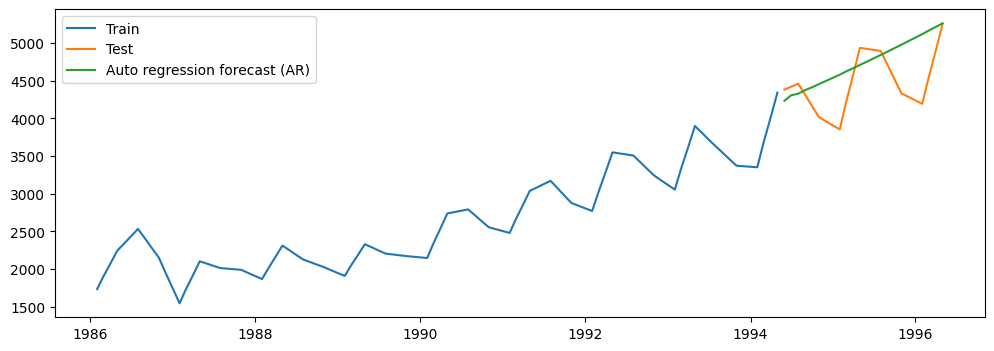

In [71]:
plt.figure(figsize=(12,4))
plt.plot(train_data['Sales'], label='Train')
plt.plot(test_data, label='Test')
plt.plot(y_hat_ar['arima_forecast'][test_data.index.min():], label='Auto regression forecast (AR)')
plt.legend(loc='best')
plt.show()

No Seasonality captured. Only Trend has been captured

# **Model Evaluation**

In [72]:
rmse_arima = np.sqrt(mean_squared_error(test_data.Sales, y_hat_ar['arima_forecast'][test_data.index.min():])).round(2)
rmse_arima

455.39

In [73]:
mape_arima = round(np.mean(np.abs((test_data.Sales - y_hat_ar['arima_forecast'][test_data.index.min():])/test_data.Sales)*100),2)
mape_arima

8.57

# **Analysing the Residuals**

In [74]:
model_residual = model_fit.resid
model_residual.mean()

0.00022566856589238094

In [75]:
adf_test(model_residual)

Reject the null hypothesis
Data is stationary


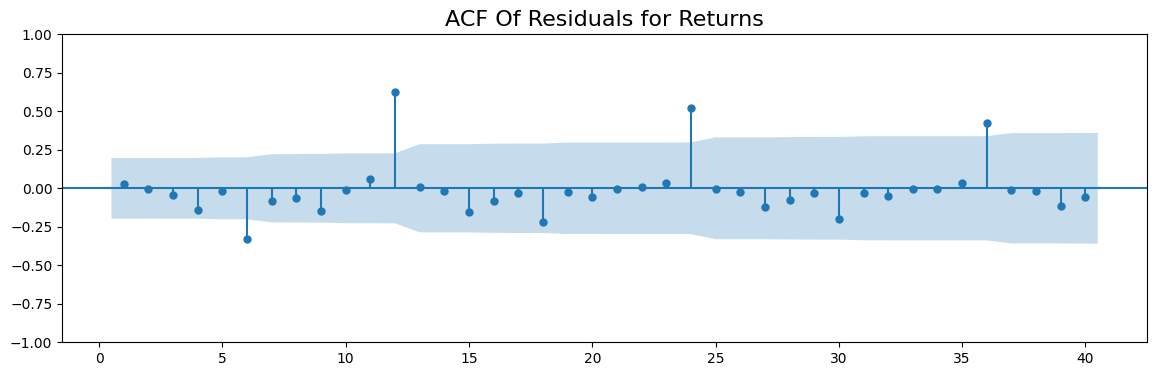

In [76]:
plt.rcParams["figure.figsize"] = (14,4)
plot_acf(model_residual, zero = False, lags = 40)
plt.title("ACF Of Residuals for Returns",size=16)
plt.show()

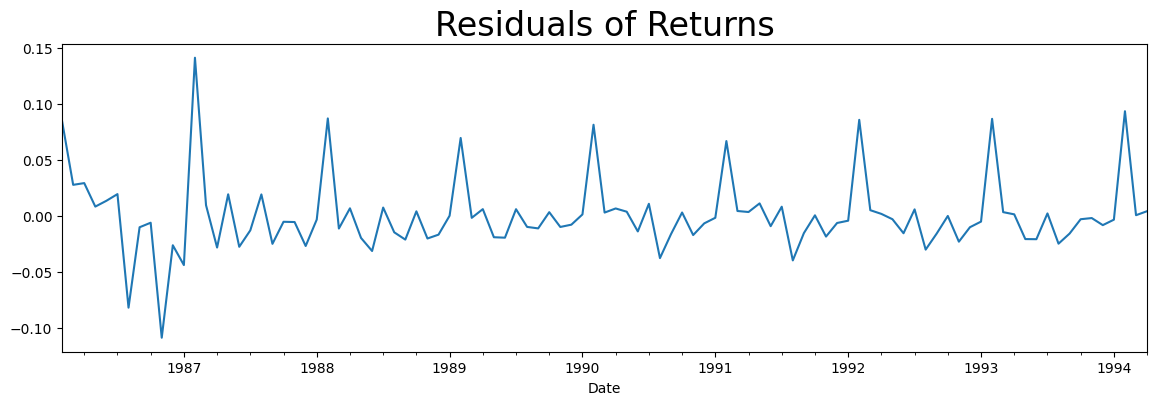

In [77]:
model_residual.plot(figsize=(14,4))
plt.title("Residuals of Returns", size=24)
plt.show()

# **Creating model with differente Transformation Technique**

In [79]:
Evaluation = {"Models":pd.Series(["Simple_Exponential","Double_Exponential","Triple_Exp_Additive","Triple_Exp_Mul_Add","Triple_Exp_Add_Mul","Triple_Exp_Multiplicative","ARIMA"]),
        "MAPE(%)":pd.Series([mape_ses,mape_dexp,mape_ad_texp,mape_mul_ad_texp,mape_ad_mul_texp,mape_mul_texp,mape_arima,]),\
        "RMSE_Values":pd.Series([test_rmse_ses,test_rmse_dexp,test_rmse_ad_texp,test_rmse_mul_ad_texp,test_rmse_ad_mul_texp,test_rmse_mul_texp,rmse_arima])}
table_evaluation=pd.DataFrame(Evaluation)
table_evaluation.sort_values(['RMSE_Values'], inplace=True, ignore_index=True)
table_evaluation

,Models,MAPE(%),RMSE_Values
0,Triple_Exp_Mul_Add,1.487269,78.733258
1,Triple_Exp_Multiplicative,1.807823,101.651349
2,Triple_Exp_Add_Mul,5.168784,270.084791
3,Simple_Exponential,6.619719,381.954224
4,ARIMA,8.570000,455.390000
5,Triple_Exp_Additive,35.695713,1828.476772
6,Double_Exponential,89.493161,4549.832594


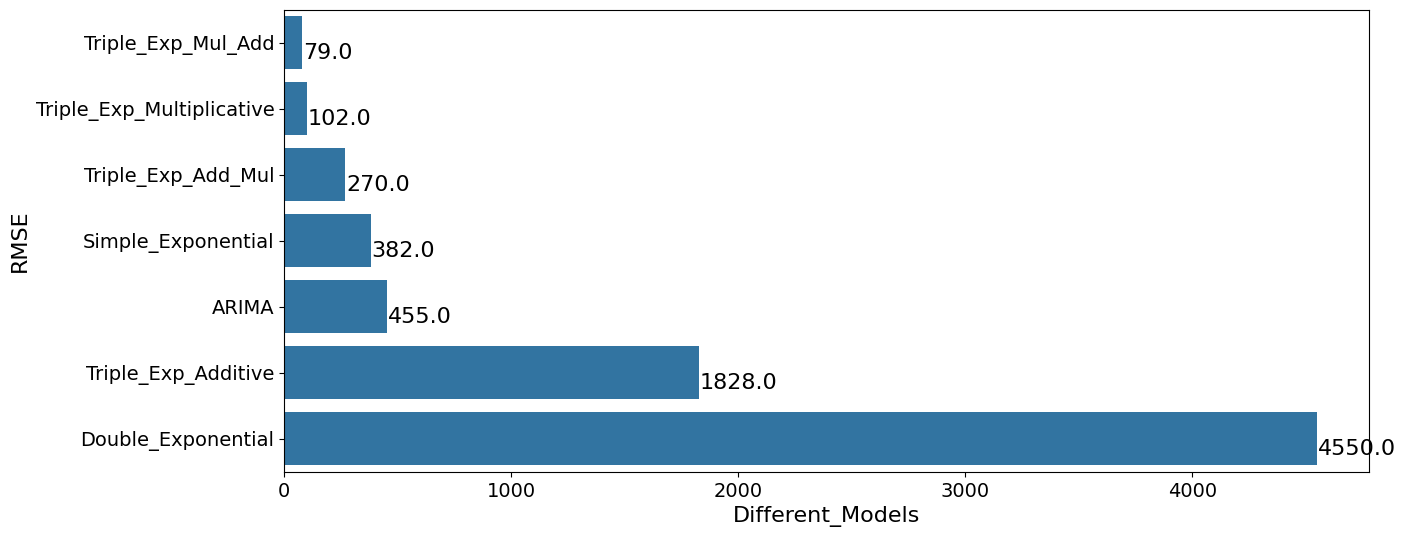

In [80]:
f, axe = plt.subplots(1,1, figsize=(14,6))
sns.barplot(x='RMSE_Values', y='Models', data=table_evaluation, ax = axe)
axe.set_xlabel('Different_Models', size=16)
axe.set_ylabel('RMSE', size=16)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

for i, v in enumerate(np.round(table_evaluation.RMSE_Values.values,0)):
    axe.text(v + 3, i + .25, str(v), fontsize= 16)

plt.show()

# **Data Pre-processing for Model Driven Techniques**

In [82]:
interpolated_month.reset_index(inplace=True)
interpolated_month['t'] = np.arange(1,len(interpolated_month)+1)
interpolated_month['t_squared'] = np.square(interpolated_month.t)
interpolated_month["month"] = interpolated_month.Date.dt.strftime("%b") # month extraction
interpolated_month["year"] = interpolated_month.Date.dt.strftime("%Y") # year extraction
months = pd.get_dummies(interpolated_month['month'])
months = months.astype(int)  # Convert to True/False
months = months[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]
cocacola = pd.concat([interpolated_month,months],axis=1)
cocacola['log_sales'] = np.log(cocacola['Sales'])
cocacola

,index,Date,Sales,t,t_squared,month,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,log_sales
0,0,1986-01-31,1734.827000,1,1,Jan,1986,1,0,0,0,0,0,0,0,0,0,0,0,7.458663
1,1,1986-02-28,1904.871666,2,4,Feb,1986,0,1,0,0,0,0,0,0,0,0,0,0,7.552170
2,2,1986-03-31,2074.916332,3,9,Mar,1986,0,0,1,0,0,0,0,0,0,0,0,0,7.637676
3,3,1986-04-30,2244.960999,4,16,Apr,1986,0,0,0,1,0,0,0,0,0,0,0,0,7.716443
4,4,1986-05-31,2341.242330,5,25,May,1986,0,0,0,0,1,0,0,0,0,0,0,0,7.758437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,119,1995-12-31,4240.333333,120,14400,Dec,1995,0,0,0,0,0,0,0,0,0,0,0,1,8.352397
120,120,1996-01-31,4194.000000,121,14641,Jan,1996,1,0,0,0,0,0,0,0,0,0,0,0,8.341410
121,121,1996-02-29,4547.000000,122,14884,Feb,1996,0,1,0,0,0,0,0,0,0,0,0,0,8.422223
122,122,1996-03-31,4900.000000,123,15129,Mar,1996,0,0,1,0,0,0,0,0,0,0,0,0,8.496990


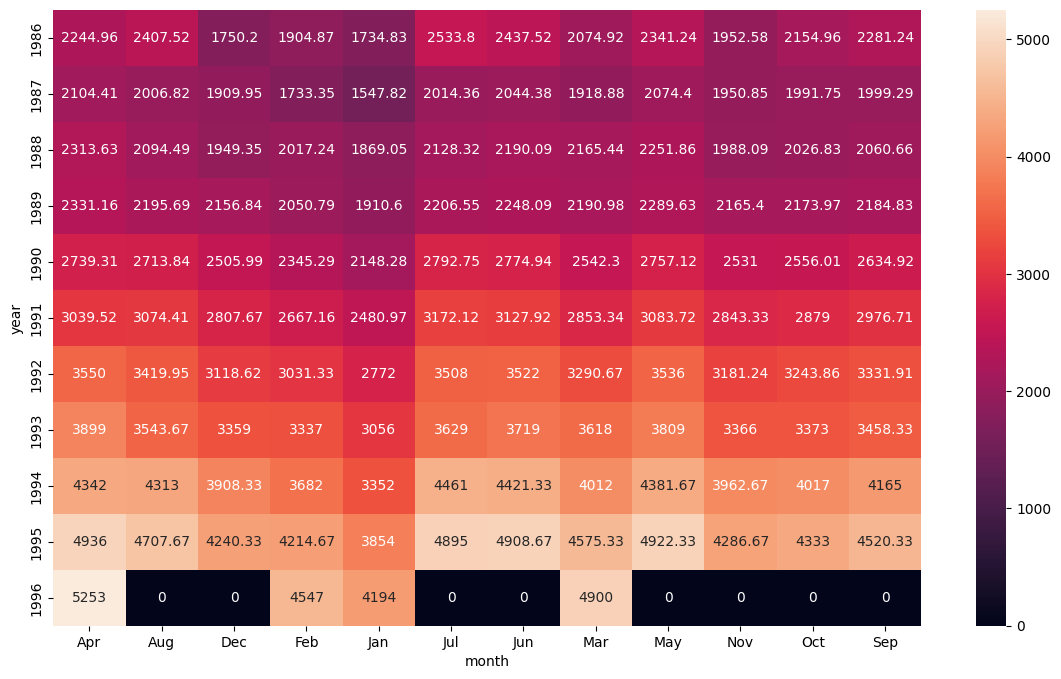

In [83]:
plt.figure(figsize=(14,8))
heatmap_y_month = pd.pivot_table(data=cocacola,values="Sales",index="year",columns="month",aggfunc="mean",fill_value=0)
sns.heatmap(heatmap_y_month,annot=True,fmt="g")
plt.show()

In [84]:
train_data = cocacola.iloc[:100]
test_data = cocacola.iloc[100:]

**1)Linear Model**

In [85]:
linear_model = smf.ols('Sales~t',data=train_data).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(test_data['t'])))
rmse_linear = np.sqrt(np.mean((np.array(test_data['Sales'])-np.array(pred_linear))**2))
rmse_linear

686.8740863668942

**2)Exponential Model**

In [86]:
exp = smf.ols('log_sales~t',data=train_data).fit()
pred_exp = pd.Series(exp.predict(pd.DataFrame(test_data['t'])))
rmse_exp = np.sqrt(np.mean((np.array(test_data['Sales'])-np.array(np.exp(pred_exp)))**2))
rmse_exp

530.326802509923

**3)Quadratic Mode**

In [87]:
quad = smf.ols('Sales~t+t_squared',data=train_data).fit()
pred_quad = pd.Series(quad.predict(test_data[["t","t_squared"]]))
rmse_quad = np.sqrt(np.mean((np.array(test_data['Sales'])-np.array(pred_quad))**2))
rmse_quad

371.29418344986675

**4)Additive seasonality**

In [88]:
add_sea = smf.ols('Sales~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=train_data).fit()
pred_add_sea = pd.Series(add_sea.predict(test_data[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]))
rmse_add_sea = np.sqrt(np.mean((np.array(test_data['Sales'])-np.array(pred_add_sea))**2))
rmse_add_sea

1837.7879723483793

**5)Additive Seasonality Quadratic**

In [89]:
add_sea_quad = smf.ols('Sales~t+t_squared+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=train_data).fit()
pred_add_sea_quad = pd.Series(add_sea_quad.predict(test_data[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','t','t_squared']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(test_data['Sales'])-np.array(pred_add_sea_quad))**2))
rmse_add_sea_quad

225.8049881036695

**6)Multiplicative Seasonality**

In [90]:
mul_sea = smf.ols('log_sales~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = train_data).fit()
pred_mult_sea = pd.Series(mul_sea.predict(test_data))
rmse_mult_sea = np.sqrt(np.mean((np.array(test_data['Sales'])-np.array(np.exp(pred_mult_sea)))**2))
rmse_mult_sea

1904.7944171920315

In [91]:
mul_add_sea = smf.ols('log_sales~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = train_data).fit()
pred_mult_add_sea = pd.Series(mul_add_sea.predict(test_data))
rmse_mult_add_sea = np.sqrt(np.mean((np.array(test_data['Sales'])-np.array(np.exp(pred_mult_add_sea)))**2))
rmse_mult_add_sea

396.41978173823406

# **Compare the results**

In [109]:
data = {"Models":pd.Series(["RMSE_Linear","RMSE_Exp","RMSE_Quad","RMSE_Add_Sea","RMSE_Add_Sea_Quad","RMSE_Mult_Sea","RMSE_Mult_Add_Sea"]),
        "RMSE_Values":pd.Series([rmse_linear,rmse_exp,rmse_quad,rmse_add_sea,rmse_add_sea_quad,rmse_mult_sea,rmse_mult_add_sea])}
table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_Values'], inplace=True, ignore_index=True)
table_rmse

,Models,RMSE_Values
0,RMSE_Add_Sea_Quad,225.804988
1,RMSE_Quad,371.294183
2,RMSE_Mult_Add_Sea,396.419782
3,RMSE_Exp,530.326803
4,RMSE_Linear,686.874086
5,RMSE_Add_Sea,1837.787972
6,RMSE_Mult_Sea,1904.794417


In [110]:
e = pd.concat([table_rmse, table_evaluation], ignore_index=True)
e.drop('MAPE(%)', axis=1, inplace=True)
e.sort_values(['RMSE_Values'], inplace=True, ignore_index=True)
e

,Models,RMSE_Values
0,Triple_Exp_Mul_Add,78.733258
1,Triple_Exp_Multiplicative,101.651349
2,RMSE_Add_Sea_Quad,225.804988
3,Triple_Exp_Add_Mul,270.084791
4,RMSE_Quad,371.294183
5,Simple_Exponential,381.954224
6,RMSE_Mult_Add_Sea,396.419782
7,ARIMA,455.390000
8,RMSE_Exp,530.326803
9,RMSE_Linear,686.874086


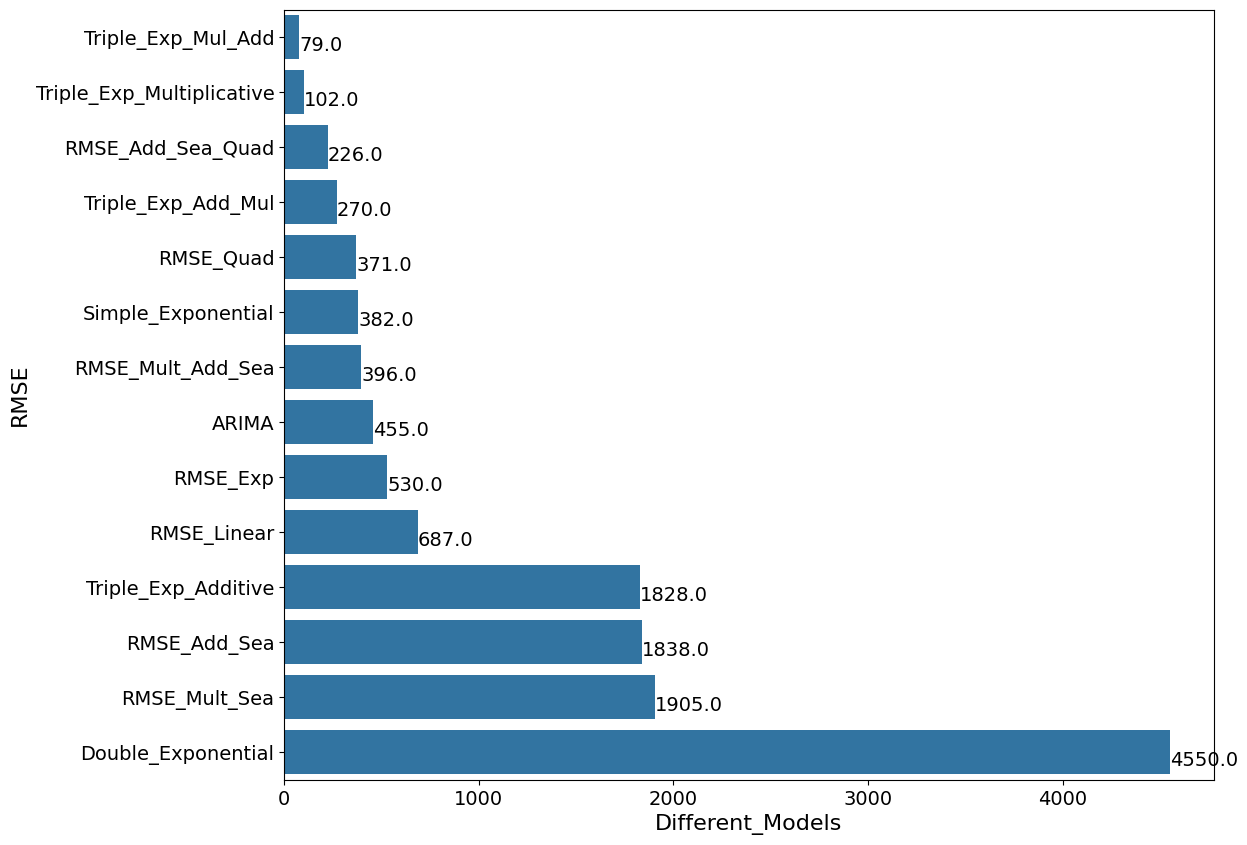

In [111]:
f, axe = plt.subplots(1,1, figsize=(12,10))
sns.barplot(x='RMSE_Values', y='Models', data=e, ax = axe)
axe.set_xlabel('Different_Models', size=16)
axe.set_ylabel('RMSE', size=16)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

for i, v in enumerate(np.round(e.RMSE_Values.values,0)):
    axe.text(v + 0.3, i + .25, str(v), fontsize= 14)

plt.show()

# **Conclusion :**
**Triple Exponential Method with Multiplicative Seasonality and Additive Trend
is the best model we have got so far with the lowest RMSE and lowest MAPE.**